# Modeling with k-means, Part 4

In Part 4 I continue to apply the methods of Parts 1, 2, and 3.  The difference is that here we are looking for 3 clusters rather than just 2.

As in Part 2, since there are so few records in the *wine* dataset (178 records, or samples), I will include all records in the training set data and compare model performance based on cross-validation scores.

The wine samples represent three varietals.






                                   * * * * *

# Preliminaries

In [ ]:
require(rattle)
require(car)
require(repr)
require(ggplot2)
require(stringr)
require(parallel)
require(faraway)
require(randomForest)
require(plyr)
require(e1071)
require(xgboost)


In [2]:
options(digits= 5, show.signif.stars= FALSE)


## Load the data

In [3]:
# Load the data.  The wine dataset is found in 
# package rattle.

data(wine, package="rattle")
dim(wine)
colnames(wine)


[1] 178  14

[1] "Type"            "Alcohol"         "Malic"           "Ash"            
 [5] "Alcalinity"      "Magnesium"       "Phenols"         "Flavanoids"     
 [9] "Nonflavanoids"   "Proanthocyanins" "Color"           "Hue"            
[13] "Dilution"        "Proline"

In [4]:
# Note that all of the predictors are numeric (continuous).
# Note that Type is a factor.

head(wine[, 1:14])


,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
2,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
3,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
4,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
5,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
6,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [5]:
tail(wine)


,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
173,3,14.16,2.51,2.48,20.0,91,1.68,0.70,0.44,1.24,9.7,0.62,1.71,660
174,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740
175,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750
176,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
177,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
178,3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [4]:
# Shuffle the data.

set.seed(1234)
smp <- sample(rownames(wine), nrow(wine), replace=FALSE)
wine <- wine[smp,]
smp02 <- sample(rownames(wine), nrow(wine), replace=FALSE)
wine <- wine[smp02,]
head(rownames(wine))
tail(rownames(wine))


[1] "113" "159" "21"  "131" "137" "133"

[1] "104" "144" "32"  "140" "28"  "168"

In [5]:
train <- wine


In [6]:
# The wine samples are from 3 grape varietals.

table(wine$Type)



 1  2  3 
59 71 48 

## Basic functions

In [6]:
# Function to output a confusion matrix and the 
# accuracy score.

get_confusion <- function(preds, df_actual) {
    
    # df_actual is a one-column dataframe;
    # preds is a named vector of predictions;
    # preds is of type factor; it is assumed there are
    # at least 2 factor levels
    
    levs <- levels(preds)
    n_levs <- length(levs)
    if(n_levs== 1) { levs <- c('0', '1') }
    n_levs <- max(n_levs, 2)
    actual <- as.vector(df_actual[, 1])
    names(actual) <- rownames(df_actual)
    
    datout <- rep(0, n_levs * (n_levs + 1))
    dim(datout) <- c(n_levs, n_levs + 1)
    datout <- as.data.frame(datout)
    colnames(datout) <- c(levs, "class.error")
    rownames(datout) <- levs
    
    result <- vector("list", length= 2)
    names(result) <- c("matrix","acc")
    
    # for each factor level, identify the rcd names
    # which should be classed as such
    for(rowlev in levs) {
        actlev_names <- names(actual[actual == rowlev])
        # columns are for the predicted values:
        for(collev in levs) {
            predlev_names <- names(preds[preds == collev])
            if(length(predlev_names > 0)) {
                datout[rowlev, collev] <- sum(predlev_names %in% actlev_names)
            }
        }
        nonrow_cols <- levs[!(levs %in% rowlev)]
        datout[rowlev, "class.error"] <- round(sum(as.vector(datout[rowlev, nonrow_cols]))/
                                               sum(as.vector(datout[rowlev, levs])), 4)
    }
    
    result$matrix <- datout
    mat <- as.matrix(datout[, 1:nrow(datout)])
    result[[2]] <- round(sum(diag(mat))/floor(sum(mat)), 4)
    
    return(result)
}


In [7]:
# The following function is from Robert Kabacoff's "R in Action", pp.379-380.

wssplot <- function(data, title="wss plot", nc=15, seed=1233) {
    
    # wss[1] is the total sum of squares when there is only
    # one cluster.  In R's kmeans help this is called 'totss'.
    # Here is another way to compute totss: 
    # ss <- function(x) sum(scale(x, scale = FALSE)^2)
    wss <- (nrow(data) - 1)*sum(apply(data, 2, var))
    for(i in 2:nc) {
        set.seed(seed)
        km_model <- suppressWarnings(kmeans(data, centers=i, iter.max=50,
                                            nstart=15))
        wss[i] <- sum(km_model$withinss)
    }
    plot(1:nc, wss, type='b', xlab="Number of clusters",
        ylab="Within groups sums of squares",
        main= title)
}


In [8]:
# Function for identifying which cluster each record
# belongs to.  

getCluster <- function(x, centers) {
    
    # x is a row of a dataframe; its columns need
    # to be in the same order as centers (a matrix'
    # constructed from kmeans)
    
    cl_dist <- apply(centers, 1, function(y) sqrt(sum((x-y)^2)))
    return(which.min(cl_dist)[1])
}


In [9]:
# Function to constrain range of data between 0 and 1.

range01 <- function(x) {(x - min(x))/(max(x) - min(x))}


In [10]:
# Function to constrain range of data between min_x and max_x.
# This function is used to transform validation data.

range02 <- function(x, min_x, max_x) {(x - min_x)/(max_x - min_x)}


In [11]:
# Function to generate combination of parameters for gridSearch;
# each combination must add to a number ~1.  Returns a dataframe, 
# each row of which is a valid combination.

# I re-factored this ftn using R's expand.grid ftn.  expand.grid
# actually takes more time to run.  This is probably due to  
# type-checking.  It appears that we also run out of memory more
# quickly when using expand.grid.  So at the moment I am 
# reverting to the deprecated section.

generate_combs <- function(arglist, tol=0.0001) {
    # arglist is a named list; each name is a column
    # name of the dataframe which goes to k-means
    
    #################################################
    # this next section is an alternative to expand.grid
    #################################################
    # if(FALSE) {
    n_args <- length(arglist)
  
    param_vlens <- rep(NA, n_args)
    for(i in 1:n_args) {
        param_vlens[i] <- length(arglist[[i]])
    }
    n_rows <- prod(param_vlens)
  
    datout <- rep(NA, n_args*n_rows)
    dim(datout) <- c(n_rows, n_args)
    datout <- as.data.frame(datout)
    colnames(datout) <- names(arglist)
  
    cprod <- 1
    for(j in 1:n_args) {
        vect <- arglist[[j]]
        val <- rep(vect, rep(cprod, length(vect)))
        datout[, j] <- rep(val, n_rows/length(val))
        cprod <- cprod*length(vect)
    }  
    # } ## end of 'if(FALSE)'
    #################################################
    
    # datout <- expand.grid(arglist, KEEP.OUT.ATTRS= FALSE)
    # colnames(datout) <- names(arglist)
    
    row_sums <- round(rowSums(datout), 4)
    names(row_sums) <- rownames(datout)
    tol <- tol
    row_sums <- row_sums[which((as.numeric(row_sums) <= (1 + tol)) & (as.numeric(row_sums) >= (1 - tol)))]
    datout <- datout[names(row_sums),]
    return(datout)
}


# Section 1: Get best models for train data

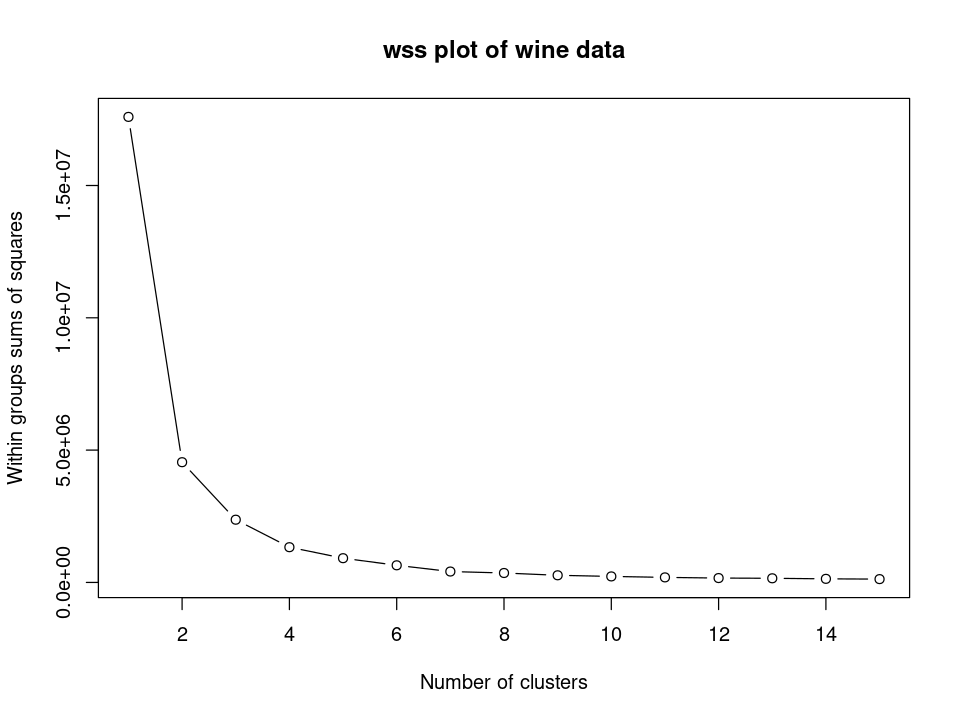

In [133]:
# Inspect the wss plot for our data.

options(repr.plot.width= 8, repr.plot.height= 6)

wssplot(train[, -1], title="wss plot of wine data")


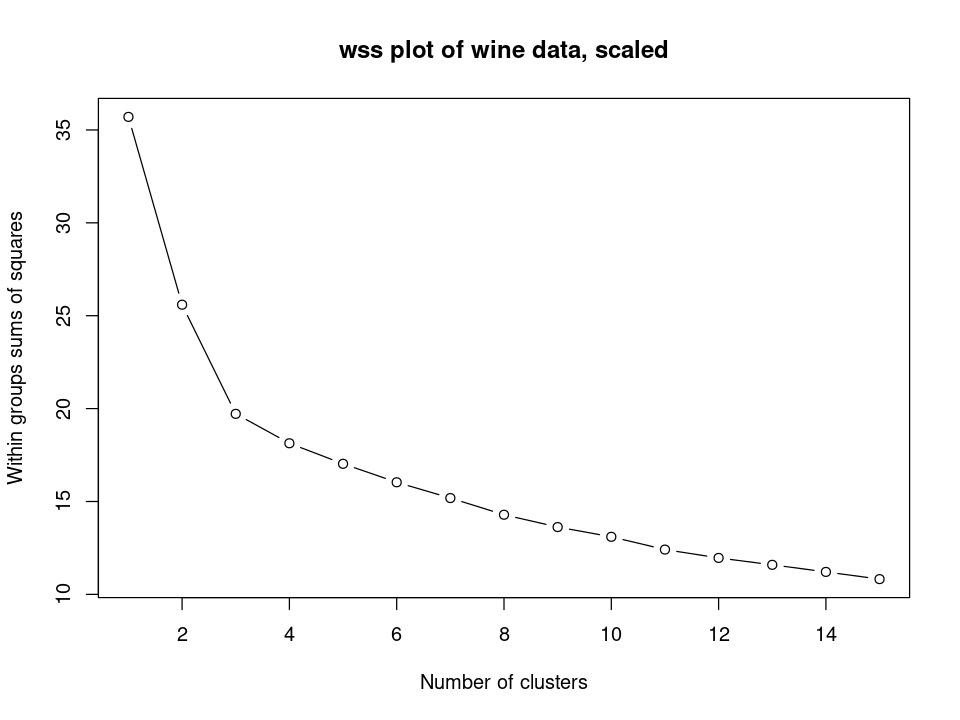

In [134]:
# Scale the data; then plot.

train_scaled <- scale(train[, -1], center=TRUE, scale=TRUE)
train_scaled <- range01(train_scaled)

options(repr.plot.width= 8, repr.plot.height= 6)

wssplot(train_scaled, title="wss plot of wine data, scaled")


In [ ]:
### COMMENT:

# We see that after scaling the data, it is easier to 
# "identify" 3 clusters.  Without the scaling, the wss
# plot makes it appear that the data is best partitioned
# into 2 classes rather than 3.


## Find best random forest model

In [56]:
# Initial model.

set.seed(123)
rfclf <- randomForest(Type ~ ., data= train,
                      ntree= 100, mtry= 3, nodesize= 1, 
                      importance=TRUE)
print(rfclf)



Call:
 randomForest(formula = Type ~ ., data = train, ntree = 100, mtry = 3,      nodesize = 1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 3

        OOB estimate of  error rate: 1.69%
Confusion matrix:
   1  2  3 class.error
1 59  0  0    0.000000
2  1 68  2    0.042254
3  0  0 48    0.000000


In [57]:
print(round(rfclf$importance, 3))


                    1      2     3 MeanDecreaseAccuracy MeanDecreaseGini
Alcohol         0.172  0.074 0.008                0.087           16.068
Malic           0.013  0.008 0.016                0.012            2.767
Ash             0.003  0.003 0.014                0.006            1.803
Alcalinity      0.012  0.003 0.030                0.012            2.804
Magnesium       0.063  0.011 0.002                0.025            3.517
Phenols         0.093  0.000 0.049                0.044            7.943
Flavanoids      0.128  0.027 0.238                0.114           17.190
Nonflavanoids   0.012 -0.002 0.004                0.005            1.364
Proanthocyanins 0.012  0.001 0.014                0.008            1.770
Color           0.107  0.091 0.135                0.109           17.491
Hue             0.052  0.015 0.130                0.057            9.597
Dilution        0.114  0.015 0.214                0.100           16.171
Proline         0.263  0.055 0.027                0

In [ ]:
### COMMENTS:

# If the models that we want to boost using k-means are too 
# powerful, the k-means algorithm will probably have nothing
# to add.  So we need to reduce the number of predictors.  
# In a previous notebook I had selected only Magnesium, Phenols,
# and Flavanoids.  Using only these 3 predictors, the typical
# cross-val accuracy score was around 87%.  The k-means 
# algorithm was still not able to improve upon the best of
# the models (an xgboost model) using only these 3 predictors.
# In the xgboost model, Phenols was insignificant relative
# to the other predictors, with a gain under 3%.  For Magnesium 
# the gain was just under 20%.  For Flavanoids, the gain was 
# almost 78%.  It may be that in order for k-means to boost
# a model's performance, we also need more balance in the 
# importance of the predictors.  We saw greater balance between 
# the 3 predictors I used in Parts 1 and 2 for the cow data.

# It is worth trying Hue, Phenols, and Alcalinity.  (See
# the above importance output.)  This choice should give us
# more balance and lower the predictive power of the models
# to a point where the k-means algorithm can have something
# to contribute.


In [ ]:
#&* Bookmark

In [12]:
train <- wine[, c("Type","Hue","Phenols","Alcalinity")]


In [13]:
set.seed(123)
rfclf <- randomForest(Type ~ ., data= train,
                      ntree= 100, mtry= 3, nodesize= 1, 
                      importance=TRUE)
print(rfclf)



Call:
 randomForest(formula = Type ~ ., data = train, ntree = 100, mtry = 3,      nodesize = 1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 3

        OOB estimate of  error rate: 20.22%
Confusion matrix:
   1  2  3 class.error
1 51  8  0     0.13559
2 11 52  8     0.26761
3  0  9 39     0.18750


In [14]:
print(round(rfclf$importance, 3))


               1     2     3 MeanDecreaseAccuracy MeanDecreaseGini
Hue        0.188 0.104 0.496                0.235           50.687
Phenols    0.342 0.041 0.229                0.192           43.940
Alcalinity 0.148 0.021 0.105                0.087           21.824


### Tune the random forest model

In [15]:
# This function is called from get_cvScore_rf.

get_Acc_rf <- function(traindat, valdat, ntrees, mtry, nodesize) {
        
    rfmod <- randomForest(Type ~ ., data= traindat, ntree= ntrees,
                          mtry= mtry, nodesize= nodesize)
        
    preds <- predict(rfmod, newdata= valdat, type="response")
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])

    return(as.numeric(ans[[2]]))
}


In [16]:
# Function to obtain a cross-validation score, averaging the
# accuracy scores of the folds.  This function is called from
# avg_seedScores_rf.

get_cvScore_rf <- function(seed, dat, ntrees, mtry,
                           nodesize, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Acc_rf, train_list, test_list,
                       MoreArgs= list(ntrees= ntrees, mtry=mtry,
                                      nodesize=nodesize),
                       SIMPLIFY= TRUE, mc.cores=5)
    
    return(round(mean(scores), 5))
}


In [17]:
# Since the seed value can have a big effect on the results,
# I take the average over a number of seeds.  This ftn is
# called from gridSearch02.

avg_seedScores_rf <- function(seed_vector, traindat, n_trees,  
                              mtry, nodesize, folds= 5) {
    
    seed_len <- length(seed_vector)
    outv <- rep(NA, seed_len)
    for(i in 1:seed_len) {
        seed <- seed_vector[i]
        outv[i] <- get_cvScore_rf(seed, traindat, n_trees,
                                  mtry, nodesize, folds=folds)
    }
    return(round(mean(outv), 5))
}


In [18]:
# This grid search is specific to finding the best random forest
# classifier for train.

gridSearch02 <- function(seed_vector, traindat, ntree_vector, 
                         mtry_vector, nodesizes, folds=5) {
    
    tree_len <- length(ntree_vector)
    mtry_len <- length(mtry_vector)
    node_len <- length(nodesizes)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * tree_len * mtry_len * node_len)
    dim(datout) <- c((tree_len * mtry_len * node_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "acc")
    datout$params <- ""
    
    index <- 0
    for(i in 1:tree_len) {
        n_trees <- ntree_vector[i]
        for(j in 1:mtry_len) {
            mtry <- mtry_vector[j]
            for(k in 1:node_len) {
                index <- index + 1
                nodesize <- nodesizes[k]
                param_string <- paste(as.character(n_trees), 
                                      as.character(mtry),
                                      as.character(nodesize), sep= "--")
                datout$params[index] <- param_string
                datout$acc[index] <- avg_seedScores_rf(seed_vector, traindat, n_trees, 
                                                         folds=folds, mtry=mtry,
                                                         nodesize=nodesize)
            }
        }
    }
    return(datout)
}


In [19]:
# Run grid search to get better parameters for the 
# random forest model.  Test with 200 seeds.  For each
# seed, an average is taken over 5 folds.

set.seed(7541)
seed_smp <- sample(1:9999, 200, replace=FALSE)
tree_vector <- c(60, 80, 100, 120, 150)
mtry_vector <- c(1, 2)
node_vector <- c(1, 2)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch02(seed_smp, train, tree_vector, mtry_vector, node_vector)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.21 mins

(best_params <- ans[which(ans$acc == max(ans$acc)),]$params)
#  '150--1--2'

(best_rf_acc <- ans[which(ans$acc == max(ans$acc)),]$acc)
#  0.80765


[1] "Start time: 2021-05-30 06:56:33"

Time difference of 2.21 mins

[1] "150--1--2"

[1] 0.80765

In [20]:
# Refine the search.

set.seed(7543)
seed_smp <- sample(1:9999, 200, replace=FALSE)
tree_vector <- c(150, 180)
mtry_vector <- c(1)
node_vector <- c(1, 2)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch02(seed_smp, train, tree_vector, mtry_vector, node_vector)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 30.33 secs

(best_params <- ans[which(ans$acc == max(ans$acc)),]$params)
#  '150--1--2'

(best_rf_acc <- ans[which(ans$acc == max(ans$acc)),]$acc)
#  0.8087


[1] "Start time: 2021-05-30 07:00:40"

Time difference of 30.33 secs

[1] "150--1--2"

[1] 0.80868

### Get an average accuracy score for rfclf_best on training set data

In [21]:
# Get stable scores for the best random forest model.  I will
# refer to this model as rfclf_best.  Note that 2000 seeds
# are being used. 

set.seed(1433)
seed_smp <- sample(1:9999, 2000, replace=FALSE)

datout <- rep(NA, 2 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 2)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed","Acc")
datout$seed <- seed_smp

start <- Sys.time()
for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    rfmod <- randomForest(Type ~ ., data= train, ntree=150,
                              mtry= 1, nodesize= 2)
        
    # preds <- predict(rfmod, newdata= dat, type="response")
    # ans <- get_confusion(preds, dat[, "Type", drop=FALSE])
    # mat <- as.matrix(ans[[1]])
    mat <- rfmod$confusion
    # percent_correct <- sum(diag(mat))/floor(sum(mat))
    # datout[i, c("Acc")] <- round(percent_correct, 4)
    datout[i, c("Acc")] <- round(1-median(rfmod$err.rate[,1]), 4)
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 21.38 secs


Time difference of 21.38 secs

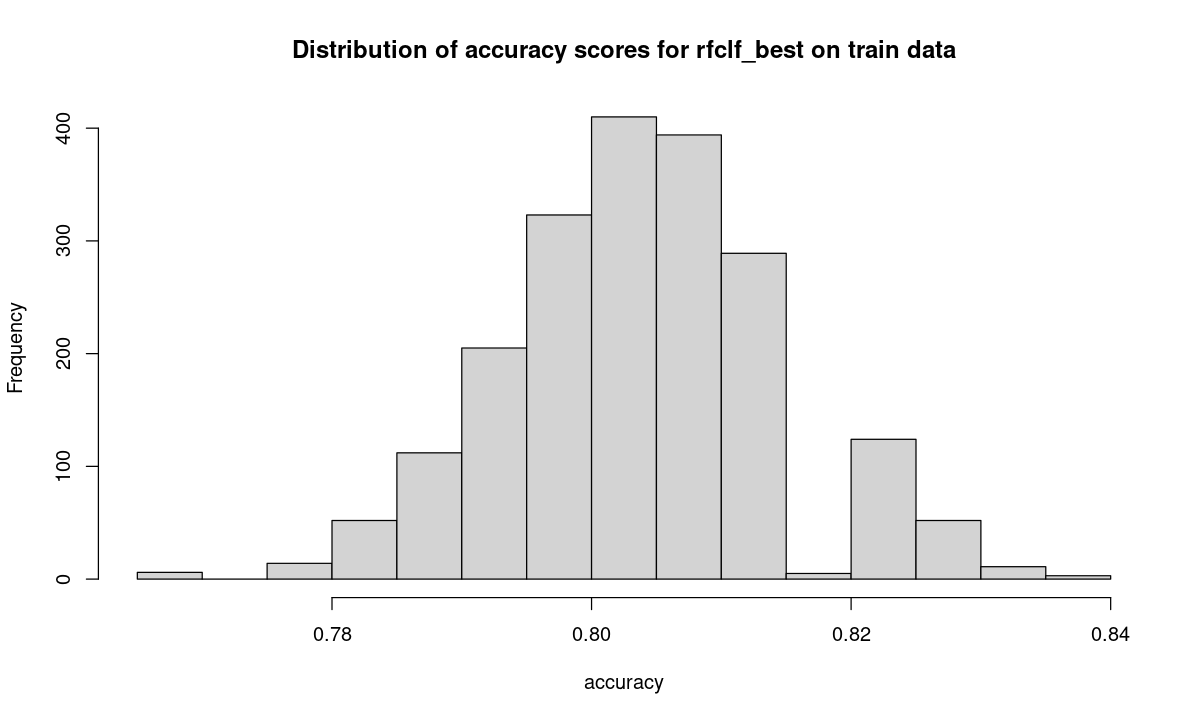

In [22]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Acc, breaks=16, xlab="accuracy",
     main="Distribution of accuracy scores for rfclf_best on train data")


In [23]:
# rfclf_best's average accuracy score on the trainset data.

round(mean(datout$Acc), 4)
# 0.8040


[1] 0.804

In [36]:
# Identify seeds with an accuracy score between 0.8039 
# and 0.8041.  When constructing rfclf_best, I want to
# use a seed which has an accuracy in the center of the
# above distribution of accuracy scores.

rf_candidate_seeds <- datout[which((datout$Acc > 0.8033) & (datout$Acc < 0.8046)),]$seed
length(rf_candidate_seeds)
#  394
head(rf_candidate_seeds)
#  2781


[1] 394

[1] 5605 8920 8072 2781  644 7123

In [37]:
# Best random forest model, for the purposes of 
# showing average performance on the training set.

set.seed(2781)
rfclf_best <- randomForest(Type ~ ., data= train, ntree=150,
                              mtry= 1, nodesize= 2)

print(rfclf_best)
# OOB estimate of  error rate: 17.98%; 32 records misclassified
# Again, this is the AVERAGE PERFORMANCE of our best rf model.



Call:
 randomForest(formula = Type ~ ., data = train, ntree = 150, mtry = 1,      nodesize = 2) 
               Type of random forest: classification
                     Number of trees: 150
No. of variables tried at each split: 1

        OOB estimate of  error rate: 17.98%
Confusion matrix:
   1  2  3 class.error
1 48 11  0     0.18644
2  8 58  5     0.18310
3  0  8 40     0.16667


## Get comparative cross-val score for best random forest model

For model performance comparisons, we want a cross-val score over many folds for our best random forest model.

In [38]:
# This function is called from get_cvScore_rfBest.  It
# returns an accuracy score on the validation set.

get_Acc_rfBest <- function(traindat, valdat) {

    # This is our current best rf model.  The seed is
    # part of the model.
    set.seed(2781)
    rfmod <- randomForest(Type ~ ., data= traindat, ntree=150,
                              mtry= 1, nodesize=2)
        
    preds <- predict(rfmod, newdata= valdat, type="response")
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [39]:
# Function to obtain a cross-validation score, averaging the
# accuracy scores of the folds.  This function is called from
# compute_cvScore_rf.

get_cvScore_rfBest <- function(seed, dat, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= nrow(dat))
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Acc_rfBest, train_list, test_list,
                       SIMPLIFY= TRUE, mc.cores=5)
    
    # The following mean is over 5 accuracy scores, one for each
    # of the folds.
    return(round(mean(scores), 5))
}


In [40]:
# Function to get a cross-val accuracy score over many 
# folds for the best random forest model.

compute_cvScore_rf <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    result <- rep(NA, length=seedv_len)
    names(result) <- as.character(seedv)
    
    for(i in 1:seedv_len) {
        cur.seed <- seedv[i]
        # For each seed in seedv, compute a cross-val
        # accuracy score.
        result[i] <- get_cvScore_rfBest(cur.seed, dat)
    }
    return(result)
}


In [41]:
# Use 2000 seeds.  This equates to getting a 
# comparative cross-val score over 10,000 folds.
# Since train has 178 records in it, each fold
# will consist of 35 or 36 records.  There are
# 1.56e37 ways of selecting 35 from 178.

set.seed(1931)
seedv <- sample(1:9999, 2000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_rf(seedv, train)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.23 mins


[1] "Start time: 2021-05-30 07:09:24"

Time difference of 1.23 mins

In [42]:
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.747   0.797   0.808   0.807   0.820   0.859 

In [43]:
# This is our comparative cross-val accuracy score for
# the current best random forest model.

round(mean(ans), 4)
# 0.8653


[1] 0.8074

In [44]:
round(median(ans), 4)
round(sd(ans), 6)
# median: 0.8085
# sd: 0.017064


[1] 0.8085

[1] 0.017064

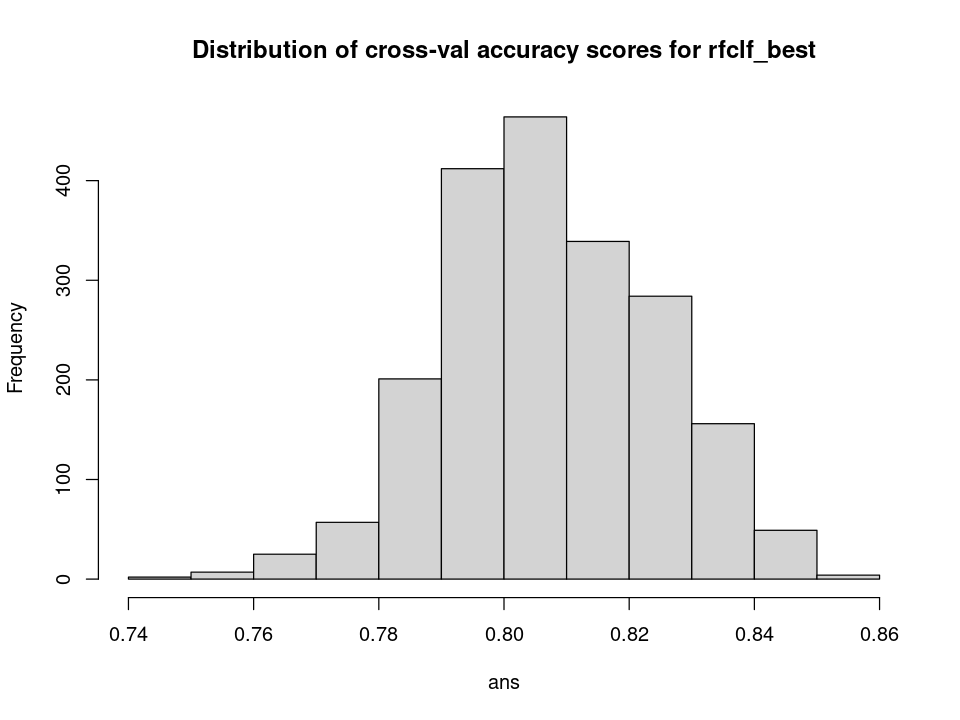

In [45]:
options(repr.plot.width= 8, repr.plot.height= 6)
hist(ans, breaks=16, main="Distribution of cross-val accuracy scores for rfclf_best")


## Find best gradient boosting model

In [34]:
# Package gbm no longer handles multinomial data.

require(xgboost)


In [58]:
# Package updates for xgboost occur regularly.

# packageDate("xgboost")
ans <- unlist(packageDescription("xgboost")[1:5])
(df <- data.frame(ans))


,ans
,<chr>
Package,xgboost
Type,Package
Title,Extreme Gradient Boosting
Version,1.4.1.1
Date,2021-04-22


In [46]:
table(train$Type)



 1  2  3 
59 71 48 

In [47]:
# We need to transform Type for xgboost to work.  The 
# classes must be numeric, starting at 0.

gbtrain <- train

gbtrain$label <- NA
for(i in 1:nrow(gbtrain)) {
    
    if(gbtrain$Type[i]== "1") { gbtrain$label[i] <- 0 }
    if(gbtrain$Type[i]== "2") { gbtrain$label[i] <- 1 }
    if(gbtrain$Type[i]== "3") { gbtrain$label[i] <- 2 }
}
table(as.factor(gbtrain$label))



 0  1  2 
59 71 48 

In [48]:
# There are 3 predictors.

colnames(gbtrain)


[1] "Type"       "Hue"        "Phenols"    "Alcalinity" "label"

In [49]:
# Remove Type column from gbtrain and make label
# the first column.

gbtrain <- gbtrain[, -1]
cols <- colnames(gbtrain)[1:3]
gbtrain <- gbtrain[, c("label", cols)]
head(gbtrain)


,label,Hue,Phenols,Alcalinity
,<dbl>,<dbl>,<dbl>,<dbl>
113,1,1.23,1.75,20
159,2,0.57,2.80,25
21,0,1.09,3.00,16
131,2,0.76,1.51,18
137,2,0.75,1.38,21
133,2,0.66,1.15,24


In [50]:
dtrain <- xgb.DMatrix(data = as.matrix(gbtrain[, -1]), label = gbtrain$label)


In [52]:
set.seed(123)
gbmod <- xgboost(data= dtrain, booster="gbtree", 
                 objective="multi:softmax", num_class=3,
                 eta= 0.25, max_depth=5, gamma=3, 
                 subsample=0.5, nrounds=8, nthread=10,
                 eval_metric="merror")


[1]	train-merror:0.191011 
[2]	train-merror:0.196629 
[3]	train-merror:0.179775 
[4]	train-merror:0.174157 
[5]	train-merror:0.174157 
[6]	train-merror:0.174157 
[7]	train-merror:0.157303 
[8]	train-merror:0.157303 


In [53]:
preds <- predict(gbmod, as.matrix(gbtrain[, -1]))
print(length(preds))
table(as.factor(preds))


[1] 178



 0  1  2 
64 69 45 

In [54]:
# Get accuracy score for the xgboost model.

preds02 <- as.factor(preds)
names(preds02) <- rownames(gbtrain)

ans <- get_confusion(preds02, gbtrain[, "label", drop=FALSE])
ans$matrix
""
ans$acc


,0,1,2,class.error
,<dbl>,<dbl>,<dbl>,<dbl>
0,53,6,0,0.1017
1,11,56,4,0.2113
2,0,7,41,0.1458


[1] ""

[1] 0.8427

      Feature    Gain   Cover Frequency
1:    Phenols 0.43449 0.36806     0.400
2:        Hue 0.40868 0.40694     0.375
3: Alcalinity 0.15684 0.22500     0.225


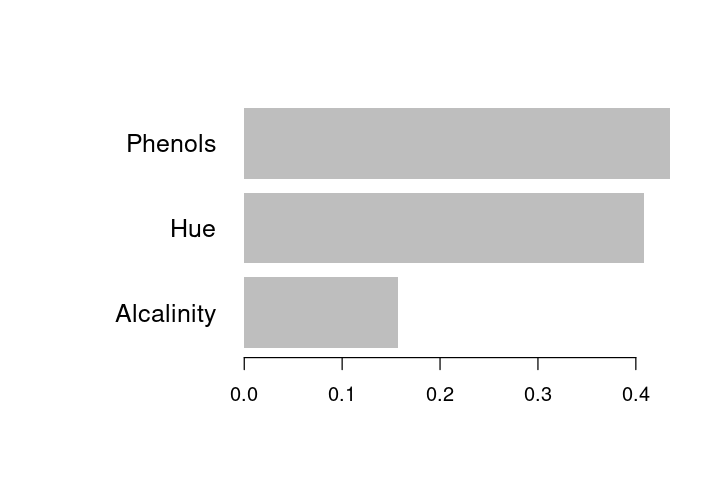

In [55]:
# Get feature importances for the gbmod model.

options(repr.plot.width= 6, repr.plot.height= 4)

importance_matrix <- xgb.importance(model = gbmod)
print(importance_matrix)
xgb.plot.importance(importance_matrix = importance_matrix)


### Tune the gradient boost model

In [56]:
# This function is called from get_cvScore_xgb.

get_Acc_xgb <- function(traindat, valdat, eta, maxDepth, gamma) {
    
    dtrain <- xgb.DMatrix(data = as.matrix(traindat[, -1]), label = traindat$label)
    
    set.seed(123)
    xgb_mod <- xgboost(data= dtrain, booster="gbtree", 
                 objective="multi:softmax", num_class=3,
                 eta=eta, max_depth=maxDepth, gamma=gamma, 
                 subsample=0.5, nrounds=8, nthread=10,
                 eval_metric="merror", verbose=0)
    
    preds <- predict(xgb_mod, as.matrix(valdat[, -1]))
    preds <- as.factor(preds)
    names(preds) <- rownames(valdat)   
    ans <- get_confusion(preds, valdat[, "label", drop=FALSE])

    return(as.numeric(ans[[2]]))
}


In [57]:
# Function to obtain a cross-validation score, averaging the
# accuracy scores of the folds.  This function is called from
# avg_seedScores_xgb.

get_cvScore_xgb <- function(seed, dat, eta, maxDepth,
                            gamma, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= nrow(dat))
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    # Do NOT use mcmapply with xgboost.  The function is 
    # already using 10 cores, or threads.
    scores <- mapply(get_Acc_xgb, train_list, test_list,
                     MoreArgs= list(eta= eta, maxDepth=maxDepth,
                                    gamma=gamma), SIMPLIFY= TRUE)
    
    return(round(mean(scores), 5))
}


In [58]:
# Since the seed value can affect the results, I take
# the average over a number of seeds.  This ftn is
# called from gridSearch02_xgb.

avg_seedScores_xgb <- function(seed_vector, traindat, eta, maxDepth, 
                               gamma, folds= 5) {
    
    seed_len <- length(seed_vector)
    outv <- rep(NA, seed_len)
    for(i in 1:seed_len) {
        seed <- seed_vector[i]
        outv[i] <- get_cvScore_xgb(seed, traindat, eta, maxDepth,
                                   gamma, folds=folds)
    }
    return(round(mean(outv), 5))
}


In [59]:
# This grid search is specific to finding the best xgboost
# classifier for traindat.

gridSearch02_xgb <- function(seed_vector, traindat, eta_vector, 
                             maxDepth_vector, gamma_vector, folds=5) {
    
    eta_len <- length(eta_vector)
    maxDepth_len <- length(maxDepth_vector)
    gamma_len <- length(gamma_vector)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * eta_len * maxDepth_len * gamma_len)
    dim(datout) <- c((eta_len * maxDepth_len * gamma_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "acc")
    datout$params <- ""
    
    index <- 0
    for(i in 1:eta_len) {
        eta <- eta_vector[i]
        for(j in 1:maxDepth_len) {
            maxDepth <- maxDepth_vector[j]
            for(k in 1:gamma_len) {
                index <- index + 1
                gamma <- gamma_vector[k]
                param_string <- paste(as.character(eta), 
                                      as.character(maxDepth),
                                      as.character(gamma), sep= "--")
                datout$params[index] <- param_string
                datout$acc[index] <- avg_seedScores_xgb(seed_vector, traindat, eta=eta, 
                                                        folds=folds, maxDepth=maxDepth,
                                                        gamma=gamma)
            }
        }
    }
    return(datout)
}


In [60]:
# Run grid search to get better parameters for the 
# xgboost model.  Test with 350 seeds.  For each
# seed, an average is taken over 5 folds.

set.seed(7541)
seed_smp <- sample(1:9999, 350, replace=FALSE)
eta_vector <- c(0.20, 0.23, 0.25)
maxDepth_vector <- 3:5
gamma_vector <- 1:2

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch02_xgb(seed_smp, gbtrain, eta_vector, maxDepth_vector, gamma_vector)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.67 mins

(best_params <- ans[which(ans$acc == max(ans$acc)),]$params)
#  '0.23--5--1'

(best_xgb_acc <- ans[which(ans$acc == max(ans$acc)),]$acc)
#  0.7940


[1] "Start time: 2021-05-30 07:16:47"

Time difference of 3.67 mins

[1] "0.23--5--1"

[1] 0.79396

In [61]:
# Refine the search.

set.seed(1933)
seed_smp <- sample(1:9999, 350, replace=FALSE)
eta_vector <- c(0.22, 0.23, 0.24)
maxDepth_vector <- 5:6
gamma_vector <- 1:2

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch02_xgb(seed_smp, gbtrain, eta_vector, maxDepth_vector, gamma_vector)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.55 mins

(best_params <- ans[which(ans$acc == max(ans$acc)),]$params)
#  '0.24--6--1'

(best_xgb_acc <- ans[which(ans$acc == max(ans$acc)),]$acc)
#  0.7936


[1] "Start time: 2021-05-30 07:21:34"

Time difference of 2.55 mins

[1] "0.24--6--1"

[1] 0.7936

### Get an average accuracy score for xgb_best on the training set

In [62]:
# Get stable scores for the best xgboost model.  I will
# refer to this model as xgb_best.  Note that 2000 seeds
# are being used. 

set.seed(1433)
seed_smp <- sample(1:9999, 2000, replace=FALSE)

datout <- rep(NA, 2 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 2)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed","Acc")
datout$seed <- seed_smp

start <- Sys.time()
for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    xgbmod <- xgboost(data= dtrain, booster="gbtree", 
                 objective="multi:softmax", num_class=3,
                 eta=0.24, max_depth=6, gamma=1, 
                 subsample=0.5, nrounds=8, nthread=10,
                 eval_metric="merror", verbose=0)
    
    preds <- predict(xgbmod, as.matrix(gbtrain[, -1]))
    preds <- as.factor(preds)
    names(preds) <- rownames(gbtrain)   
    ans <- get_confusion(preds, gbtrain[, "label", drop=FALSE])
    
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    datout[i, c("Acc")] <- round(percent_correct, 4)
    
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 16 secs


Time difference of 16.06 secs

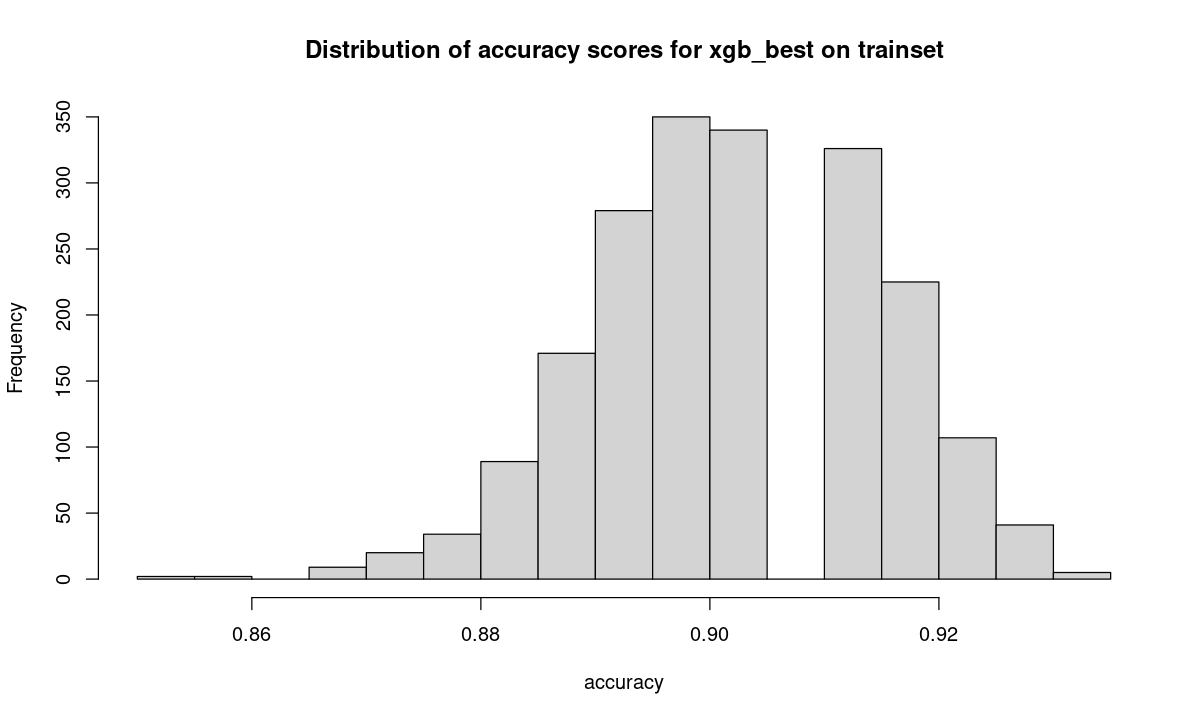

In [63]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Acc, breaks=16, xlab="accuracy",
     main="Distribution of accuracy scores for xgb_best on trainset")


In [64]:
# xgb_best's average accuracy score on the trainset data.

round(mean(datout$Acc), 4)
# For rfclf_best we had an accuracy score of 0.8040

# 0.902


[1] 0.902

In [76]:
# Identify seeds with an accuracy score near 0.9020.

xgb_candidate_seeds <- datout[which((datout$Acc > 0.8990) & (datout$Acc < 0.9050)),]$seed
length(xgb_candidate_seeds)
#  340
head(xgb_candidate_seeds)
#  4998


[1] 340

[1] 3837  947  381 4998 2141 4887

In [77]:
# Best xgb_boost model for the purposes of showing
# average performance on the training set.  The seed 
# value is part of the model.

set.seed(4998)
xgb_best <- xgboost(data= dtrain, booster="gbtree", 
                 objective="multi:softmax", num_class=3,
                 eta=0.24, max_depth=6, gamma=1, 
                 subsample=0.5, nrounds=8, nthread=10,
                 eval_metric="merror", verbose=0)


In [78]:
# Get accuracy score for xgb_best.

preds <- predict(xgb_best, as.matrix(gbtrain[, -1]))
preds <- as.factor(preds)
names(preds) <- rownames(gbtrain)   
ans <- get_confusion(preds, gbtrain[, "label", drop=FALSE])
   
acc <- round(as.numeric(ans[[2]]), 4)
print(acc)
# 0.9045

# This is the AVERAGE PERFORMANCE of our best xgboost model on
# the training set.


[1] 0.9045


In [79]:
# xgb_best misclassifies, on average, 17 of the 178
# records.  rfclf_best misclassified, on average, 32 
# of the 178 records.  These are scores on the training set.

ans[[1]]


,0,1,2,class.error
,<dbl>,<dbl>,<dbl>,<dbl>
0,55,4,0,0.0678
1,6,61,4,0.1408
2,0,3,45,0.0625


## Get comparative cross-val score for best xgboost model

In [80]:
# This function is called from get_cvScore_xgbBest.
# It returns an accuracy score on the validation set.

get_Acc_xgbBest <- function(traindat, valdat) {
    
    dtrain <- xgb.DMatrix(data = as.matrix(traindat[, -1]), 
                          label = traindat$label)
 
    # This is our current best xgboost model.
    set.seed(4998)
    xgbmod <- xgboost(data= dtrain, booster="gbtree", 
                      objective="multi:softmax", num_class=3,
                      eta=0.24, max_depth=6, gamma=1, 
                      subsample=0.5, nrounds=8, nthread=10,
                      eval_metric="merror", verbose=0)
        
    preds <- predict(xgbmod, as.matrix(valdat[, -1]))
    preds <- as.factor(preds)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "label", drop=FALSE])
    return(ans[[2]])
}


In [81]:
# Function to obtain a cross-validation score, averaging the
# accuracy scores of the folds.  This function is called from
# compute_cvScore_xgb.

get_cvScore_xgbBest <- function(seed, dat, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= nrow(dat))
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    # Do NOT use mcmapply with xgboost.  The function is 
    # already using 10 cores, or threads.
    scores <- mapply(get_Acc_xgbBest, train_list, test_list,
                     SIMPLIFY= TRUE)
    
    # The following average is over the 5 folds created using
    # the current seed.
    return(round(mean(scores), 5))
}


In [82]:
# Function to get a cross-val accuracy score over many 
# folds for the best xgboost model.

compute_cvScore_xgb <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    result <- rep(NA, length=seedv_len)
    names(result) <- as.character(seedv)
    
    for(i in 1:seedv_len) {
        cur.seed <- seedv[i]
        # For each seed in seedv, compute a cross-val
        # accuracy score.
        result[i] <- get_cvScore_xgbBest(cur.seed, dat)
    }
    return(result)
}


In [83]:
head(gbtrain)


,label,Hue,Phenols,Alcalinity
,<dbl>,<dbl>,<dbl>,<dbl>
113,1,1.23,1.75,20
159,2,0.57,2.80,25
21,0,1.09,3.00,16
131,2,0.76,1.51,18
137,2,0.75,1.38,21
133,2,0.66,1.15,24


In [84]:
# Use the same initial seed as we did to get the 
# corresponding score for the random forest model.

set.seed(1931)
seedv <- sample(1:9999, 2000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_xgb(seedv, gbtrain)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.24 mins


[1] "Start time: 2021-05-30 07:35:28"

Time difference of 1.23 mins

In [85]:
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.719   0.780   0.792   0.792   0.804   0.849 

In [86]:
# This is our comparative cross-val accuracy score for the
# current best gradient boosting model.

round(mean(ans), 4)
# 0.7920


[1] 0.792

In [87]:
round(median(ans), 4)
round(sd(ans), 6)
# 0.7925
# 0.019219


[1] 0.7925

[1] 0.019219

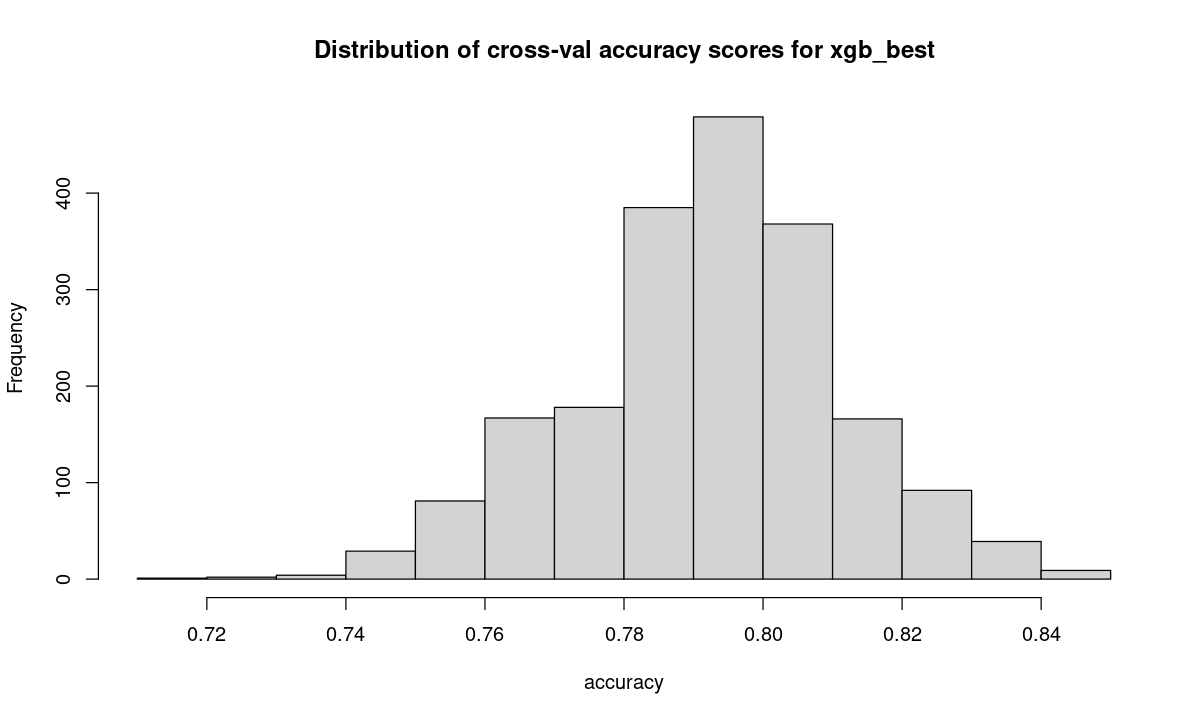

In [88]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(ans, breaks=16, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for xgb_best")


## SVM classifier

In [13]:
summary(train[, -1])

# All variables are numeric and positive.


      Hue           Phenols       Alcalinity  
 Min.   :0.480   Min.   :0.98   Min.   :10.6  
 1st Qu.:0.782   1st Qu.:1.74   1st Qu.:17.2  
 Median :0.965   Median :2.35   Median :19.5  
 Mean   :0.957   Mean   :2.30   Mean   :19.5  
 3rd Qu.:1.120   3rd Qu.:2.80   3rd Qu.:21.5  
 Max.   :1.710   Max.   :3.88   Max.   :30.0  

In [89]:
# For SVM modeling, we need to scale the data.  In 
# Parts 1 and 2 we got a better model if we scaled
# the data without applying any prior transformations.
# I will take the same approach with this data set.

svmtrain <- train

svm_scaled <- scale(svmtrain[, -1])
summary(svm_scaled)


      Hue            Phenols          Alcalinity      
 Min.   :-2.089   Min.   :-2.1013   Min.   :-2.66350  
 1st Qu.:-0.765   1st Qu.:-0.8830   1st Qu.:-0.68720  
 Median : 0.033   Median : 0.0957   Median : 0.00151  
 Mean   : 0.000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.: 0.711   3rd Qu.: 0.8067   3rd Qu.: 0.60039  
 Max.   : 3.292   Max.   : 2.5324   Max.   : 3.14564  

In [90]:
# Attach response variable.

svm_scaled <- as.data.frame(cbind(svmtrain$Type, svm_scaled),
                            row.names=rownames(svmtrain))
colnames(svm_scaled) <- colnames(svmtrain)


In [91]:
# Try with kernel = radial basis function.

svm01 <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 0.01, cost= 30, scale=FALSE)

preds <- as.factor(fitted(svm01))
ans <- get_confusion(preds, svm_scaled[, "Type", drop=FALSE])
print(ans[[1]])
""
paste0("Accuracy score for svm model: ", as.character(ans[[2]]))


   1  2  3 class.error
1 48 11  0      0.1864
2 10 56  5      0.2113
3  0  3 45      0.0625


[1] ""

[1] "Accuracy score for svm model: 0.8371"

### Tune the svm model

In [92]:
# Function to compute an accuracy score for an svm cv-fold.

get_Acc_svm <- function(traindat, valdat, gamma, cost) {
    
    # Scale traindat.
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(traindat$Type, train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Type)) ~ ., data= train_scaled, gamma=gamma,
                    cost=cost, scale=FALSE, kernel="radial")
    
    # Scale valdat.
    test_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    test_scaled <- as.data.frame(test_scaled, row.names=rownames(valdat))
    
    preds <- as.factor(predict(svmmod, newdata= test_scaled))
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [93]:
# This grid search searches for the best parameters for svm
# modeling of the data. 

gridSearch_svm <- function(seedv, dat, gammav, costv, folds=5) {
    
    gamma_len <- length(gammav)
    cost_len <- length(costv)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * gamma_len * cost_len)
    dim(datout) <- c((gamma_len * cost_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Acc")
    datout$params <- ""
    
    # Divide dat by the number of folds to get a
    # size for each fold.
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    index <- 0
    for(i in 1:gamma_len) {
        gamma <- gammav[i]
        for(j in 1:cost_len) {
            index <- index + 1
            cost <- costv[j]
            param_string <- paste(as.character(gamma), 
                                  as.character(cost), sep= "--")
            datout$params[index] <- param_string
            
            # Each set of parameters gets tested over many folds.
            # The different folds are created using different seeds.
    
            # Create a vector to store the Acc score for each seed.
            seedv_len <- length(seedv)
            seed_scores <- rep(NA, seedv_len)
    
            for(h in 1:seedv_len) {
                # shuffle dat
                cur_seed <- seedv[h]
                set.seed(cur_seed)
                smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
                dat <- dat[smp,]
    
                # Each element of row_list will be the rows we pick
                # out for one of the folds.  E.g., the first element
                # of row_list will contain the rows we want for the
                # first fold, the second element of row_list will
                # contain the rows we want for the second fold, and
                # so forth.
                row_list <- vector("list", length=folds)
                names(row_list) <- as.character(1:folds)
                startpt <- 1
                for(k in 1:folds) {
                    endpt <- startpt + segmentsv[k] - 1
                    stopifnot(endpt <= nrow(dat))
                    row_list[[k]] <- rownames(dat)[startpt:endpt]
                    startpt <- endpt + 1
                }
                
                train_list <- test_list <- vector("list", length= folds)
                for(k in 1:folds) {
                    testdat <- dat[row_list[[k]],]
                    traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                    stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                    test_list[[k]] <- testdat
                    train_list[[k]] <- traindat
                }
                
                # When there are only 5 folds, only 5 cores get used.
                scores <- mcmapply(get_Acc_svm, train_list, test_list,
                                   MoreArgs= list(gamma=gamma, cost=cost),
                                   SIMPLIFY= TRUE, mc.cores=5)
                # For the current seed, store the average of the accuracy
                # scores, the average taken over the folds.
                seed_scores[h] <- round(mean(scores), 5)
        
            } ## end of for-loop, index h
            
            # Here I am taking an average of average scores.  This
            # could be improved by simply taking a single average.
            datout$Acc[index] <- round(mean(seed_scores), 5)
            
        } ## end of for-loop, index j
    } ## end of for-loop, index i
    
    return(datout)
}


In [94]:
# Find the best set of parameters.

set.seed(7543)
seed_vector <- sample(1:9999, 200, replace=FALSE)

gamma_v <- seq(0.01, 0.1, by=0.01)
cost_v <- seq(10, 50, by=10)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, svmtrain, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.19 mins

(best_params <- ans[which(ans$Acc == max(ans$Acc)),]$params)
# '0.03--30'

(best_Acc <- ans[which(ans$Acc == max(ans$Acc)),]$Acc)
# 0.8281


[1] "Start time: 2021-05-30 07:41:47"

Time difference of 5.19 mins

[1] "0.03--30"

[1] 0.82814

In [95]:
# Refine the search.

set.seed(1981)
seed_vector <- sample(1:9999, 250, replace=FALSE)

gamma_v <- seq(0.02, 0.04, by=0.01)
cost_v <- c(25, 30, 35)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, svmtrain, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.17 mins

(best_params <- ans[which(ans$Acc == max(ans$Acc)),]$params)
# '0.03--25'

(best_Acc <- ans[which(ans$Acc == max(ans$Acc)),]$Acc)
# 0.8281


[1] "Start time: 2021-05-30 07:48:50"

Time difference of 1.17 mins

[1] "0.03--25"

[1] 0.82811

### Get scores for best svm (svm02)

In [96]:
# Construct an svm with the identified parameters.

# Set probability=TRUE in order to get probability estimates
# from the output.
svm02 <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)

preds <- as.factor(fitted(svm02))
ans <- get_confusion(preds, svm_scaled[, "Type", drop=FALSE])
print(ans[[1]])
""
paste0("Accuracy score for svm02 (best svm): ", as.character(ans[[2]]))
# 0.8596

# 25 of the 178 records are misclassified.


   1  2  3 class.error
1 55  4  0      0.0678
2 12 53  6      0.2535
3  0  3 45      0.0625


[1] ""

[1] "Accuracy score for svm02 (best svm): 0.8596"

## Get comparative cross-val score for best svm model

In [97]:
# Function to obtain a cross-validation score, averaging the
# accuracy scores of the folds.  This function is called from
# compute_cvScore_svm.

get_cvScore_svm02 <- function(seed, dat, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= nrow(dat))
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Acc_svm, train_list, test_list,
                       MoreArgs= list(gamma=0.03, cost=25),
                       SIMPLIFY= TRUE, mc.cores=5)
    
    # The following average is over the 5 folds created using
    # the current seed.
    return(round(mean(scores), 5))
}


In [98]:
# Function to get a cross-val accuracy score over many 
# folds for the svm02 model.

compute_cvScore_svm <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    result <- rep(NA, length=seedv_len)
    names(result) <- as.character(seedv)
    
    for(i in 1:seedv_len) {
        cur.seed <- seedv[i]
        # For each seed in seedv, compute a cross-val
        # accuracy score.
        result[i] <- get_cvScore_svm02(cur.seed, dat)
    }
    return(result)
}


In [99]:
# Again, use the same initial seed we used for
# these scores above.  The result is over 10000 folds.

set.seed(1931)
seed_vector <- sample(1:9999, 2000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_svm(seed_vector, svmtrain)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.04 mins


[1] "Start time: 2021-05-30 07:53:25"

Time difference of 1.04 mins

In [100]:
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.782   0.820   0.827   0.828   0.837   0.866 

In [101]:
# This is our comparative cross-val accuracy score for the
# current best svm model.

round(mean(ans), 4)
# 0.8278


[1] 0.8278

In [102]:
round(median(ans), 4)
round(sd(ans), 6)
# median: 0.8271
# sd: 0.012713


[1] 0.8271

[1] 0.012713

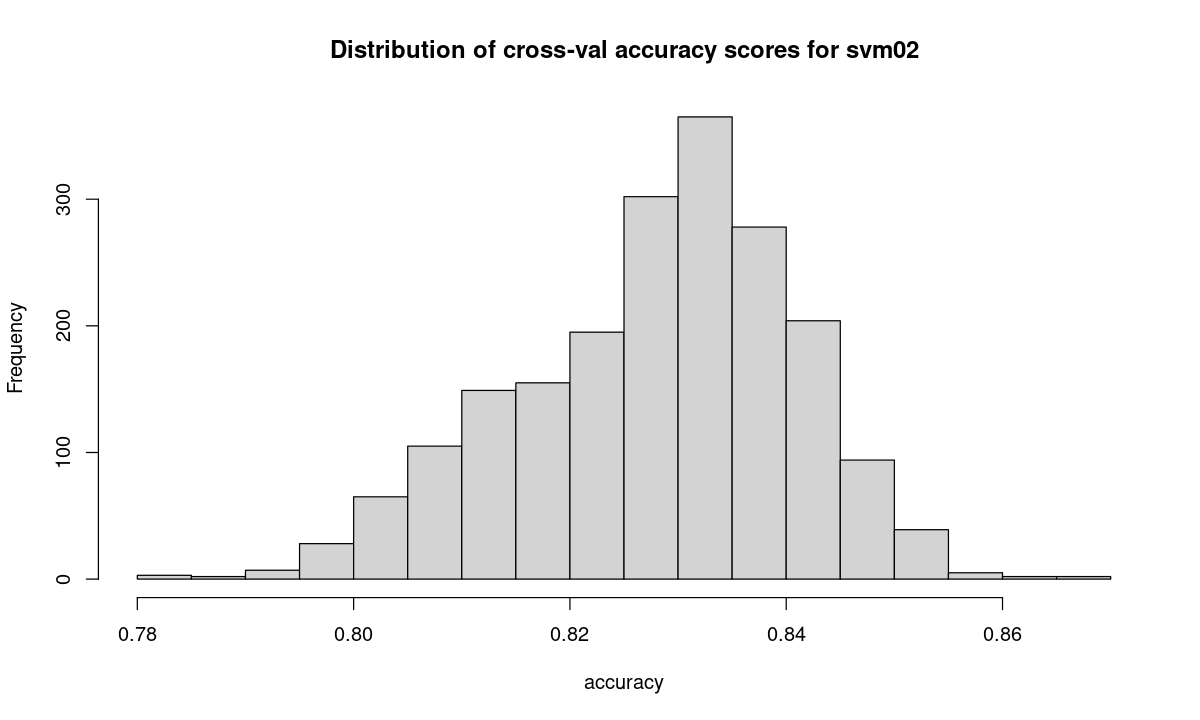

In [103]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(ans, breaks=16, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for svm02")


In [ ]:
### COMMENTS (RESULTS THUS FAR):

# Thus far, svm02 is our best model.  It has a cross-val score 
# of 0.8278.  This equates to an average of 30.65 misclassified
# for every 178 records.
# The next best model is rfclf_best.  It has a cross-val score
# of 0.8074; this equates to an average of 34.28 misclassified
# for every 178 records.



# Section 2: k-means models, base and initial hybrid

## Base k-means model

In Parts 1 and 2 we were able to find a k-means hybrid model which outperformed all competing models.  One thing that likely made this possible was that the base k-means model itself was nearly as good classifying the data as any of the other best models.  With the current example, the base k-means model does not perform nearly as well as the models we have already looked at.

Among other things, this means that it will likely be more difficult to construct a hybrid k-means model which outperforms svm02.  It is much more difficult for the k-means algorithm to contribute something additional to the classification task when it has low performance on that task relative to the other models.  Another disadvantage for our hybrid model, relative to what we saw in Parts 1 and 2, is that here we have to beat an accuracy score of almost 83% on 178 records, whereas in Part 2 (for example) we had to beat an accuracy score of around 70.5% on 400 records.  Thus, with the wine dataset, the bar is much higher.  I could lower it a bit by choosing a different set of 3 predictors, but let's see what happens.



                                    * * * * *

In [104]:
# First scale the data.  Two kinds of scaling are
# being applied here.  In Section 5 below, I employ
# a different approach to scaling.

df <- train

df02 <- scale(df[, -1], center=TRUE, scale=TRUE)

# Apply min-max scaling, moving all values between 0 and 1.
df_scaled <- apply(as.matrix(df02), MARGIN=2, range01)
df_scaled <- as.data.frame(cbind(df$Type, df_scaled),
                           row.names=rownames(df))
colnames(df_scaled) <- colnames(df)
summary(df_scaled[, -1])


      Hue           Phenols        Alcalinity   
 Min.   :0.000   Min.   :0.000   Min.   :0.000  
 1st Qu.:0.246   1st Qu.:0.263   1st Qu.:0.340  
 Median :0.394   Median :0.474   Median :0.459  
 Mean   :0.388   Mean   :0.453   Mean   :0.459  
 3rd Qu.:0.520   3rd Qu.:0.628   3rd Qu.:0.562  
 Max.   :1.000   Max.   :1.000   Max.   :1.000  

In [105]:
# Run k-means with number of clusters set to 3.

set.seed(1233)
fit_km <- kmeans(df_scaled[, -1], 3, iter.max = 50, nstart = 30)
print(fit_km$size)


[1] 74 44 60


In [106]:
datout <- as.data.frame(cbind(df_scaled$Type, fit_km$cluster))
colnames(datout) <- c("Type", "cluster")
rownames(datout) <- rownames(df_scaled)
head(datout)


,Type,cluster
,<dbl>,<dbl>
113,2,2
159,3,2
21,1,1
131,3,3
137,3,3
133,3,3


In [107]:
# We need to map cluster to Type level.

table(datout$Type, as.factor(datout$cluster))


   
     1  2  3
  1 50  9  0
  2 24 32 15
  3  0  3 45

In [108]:
ans <- as.matrix(table(datout$Type, as.factor(datout$cluster)))
print(apply(ans, MARGIN=2, which.max))


1 2 3 
1 2 3 


In [109]:
# Code snippet from get_mapping function (see below).
# (The point of this cell is to show output for a 
# section of the code in get_mapping.)

ans <- table(datout$Type, as.factor(datout$cluster))
    
    # For each cluster, pick out the row (i.e., Type level) which
    # the cluster will almost certainly not map to.
    min_levs <- apply(ans, MARGIN=2, which.min)
    c1_minlev <- as.numeric(min_levs["1"])
    c2_minlev <- as.numeric(min_levs["2"])
    c3_minlev <- as.numeric(min_levs["3"])
    
    # For each cluster, identify the remaining Type levels to
    # which it could map.
    c1levs <- c(1:3)[which(!(1:3 %in% c1_minlev))]
    c2levs <- c(1:3)[which(!(1:3 %in% c2_minlev))]
    c3levs <- c(1:3)[which(!(1:3 %in% c3_minlev))]
    tmpdat <- rbind(c1levs, c2levs, c3levs)
    colnames(tmpdat) <- 1:(dim(ans)[1] - 1)

tmpdat


,1,2
c1levs,1,2
c2levs,1,2
c3levs,2,3


In [ ]:
#&* Bookmark

In [13]:
# Helper function for function valid_mappings.

all_levels <- function(rowvals, levs) {
    
    n_levels <- length(levs)
    result <- FALSE
    
    if(sum(levs %in% rowvals) == n_levels) result <- TRUE
    return(result)
}


In [111]:
# Apply mapping resulting from fit_km above.

tmpdat <- datout
tmpdat[which(tmpdat$cluster== 1),]$Type <- 1
tmpdat[which(tmpdat$cluster== 2),]$Type <- 2
tmpdat[which(tmpdat$cluster== 3),]$Type <- 3
dim(tmpdat)


[1] 178   2

In [112]:
# Generate confusion matrix for the k-means clusters.
# Output accuracy for this confusion matrix.

preds <- as.factor(tmpdat$Type)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, df_scaled[, "Type", drop=FALSE])
print(ans$matrix)
''
print(paste("Accuracy score for the base k-means model: ", as.character(ans[[2]]), sep=""))
# 0.7135


   1  2  3 class.error
1 50  9  0      0.1525
2 24 32 15      0.5493
3  0  3 45      0.0625


[1] ""

[1] "Accuracy score for the base k-means model: 0.7135"


## Get comparative cross-val score for the base k-means model

In [113]:
ans <- as.vector(table(train$Type))
names(ans) <- levels(train$Type); print(ans)


 1  2  3 
59 71 48 


In [14]:
# Function returning a list of possible mappings 
# between the k-means clusters and the Type levels.

valid_mappings <- function(df, levs) {
    
    # Row 1 of df is for cluster 1, row 2 for 
    # cluster 2, and so forth.  Each row of df
    # lists the Type levels the given cluster
    # might be assigned to.
    df_asList <- split(df, seq(nrow(df)))
    ans <- expand.grid(df_asList, KEEP.OUT.ATTRS=FALSE)
    valid_rows <- apply(as.matrix(ans), MARGIN=1, FUN=all_levels, levs=levs)
    return(ans[valid_rows,])
}


In [15]:
# Function returning mapping between clusters and
# Type levels.  As currently written, this function
# only works for 3-cluster solutions.  We choose the
# mapping that yields the best accuracy score.

### NOTE: Choosing the mapping that yields the best
### accuracy score does not give the k-means algorithm
### an advantage over other algorithms.  This is 
### because we are comparing models based on how they
### perform on new data, and the mapping we settle upon
### is based on the training set data, not the validation
### set.

get_mapping <- function(dat, type_levels=c(1,2,3)) {
    
    # Returns a named vector on which a lookup can be done
    # by cluster name.  Values of the vector are the Type
    # levels.
    
    # dat is a dataframe with 2 columns, c("Type","cluster");
    # nrow(dat) = number of predictions from the model;
    # dat$Type = traindat$Type (from the calling function)
    
    # We find the correct mapping between cluster number and 
    # Type level by computing accuracy scores for the different
    # valid mappings.   We choose the mapping with the best
    # accuracy score.
    
    tbl <- as.matrix(table(dat$Type, as.factor(dat$cluster)))
    # The colnames of tbl refer to the names of the clusters.
    # initial_map <- apply(tbl, MARGIN=2, which.max)
    # The names for initial_map are the cluster names; the
    # values are the Type levels.
    # c1_init <- as.numeric(initial_map["1"])
    # c2_init <- as.numeric(initial_map["2"])
    # c3_init <- as.numeric(initial_map["3"])
    # Ideally we have c1_init <> c2_init, c1_init <> c3_init, 
    # and c2_init <> c3_init
    
    # For each cluster, pick out the row (i.e., Type level) which
    # the cluster will almost certainly not map to.
    min_levs <- apply(tbl, MARGIN=2, which.min)
    c1_minlev <- as.numeric(min_levs["1"])
    c2_minlev <- as.numeric(min_levs["2"])
    c3_minlev <- as.numeric(min_levs["3"])
    
    # For each cluster, identify the remaining Type levels to
    # which it could map.
    c1levs <- c(1:3)[which(!(1:3 %in% c1_minlev))]
    c2levs <- c(1:3)[which(!(1:3 %in% c2_minlev))]
    c3levs <- c(1:3)[which(!(1:3 %in% c3_minlev))]
    tmpdat01 <- rbind(c1levs, c2levs, c3levs)
    colnames(tmpdat01) <- 1:(dim(tbl)[1] - 1)
    
    
    # Identify valid candidate mappings.
    df_maps <- valid_mappings(tmpdat01, type_levels)
    rownames(df_maps) <- 1:nrow(df_maps)
    
    scores <- rep(NA, nrow(df_maps))    
    for(i in 1:nrow(df_maps)) {
        
        cand_levs <- df_maps[i,]
        # colnames(df_maps) are the cluster names:
        names(cand_levs) <- colnames(df_maps)
        
        tmpdat <- dat
        tmpdat[which(tmpdat$cluster== 1),]$Type <- as.numeric(cand_levs["1"])
        tmpdat[which(tmpdat$cluster== 2),]$Type <- as.numeric(cand_levs["2"])
        tmpdat[which(tmpdat$cluster== 3),]$Type <- as.numeric(cand_levs["3"])
        
        preds <- as.factor(tmpdat$Type)
        names(preds) <- rownames(tmpdat)
        ans <- get_confusion(preds, dat[, "Type", drop=FALSE])
        scores[i] <- ans[[2]]
    }
    
    # I am transposing the extracted row in order to convert
    # object to a vector.
    vals <- t(df_maps[which.max(scores)[1],])[, 1]
    vals <- as.vector(vals)
    names(vals) <- colnames(df_maps)
    return(vals)
}


In [116]:
# Function for obtaining average of confusion matrix 
# accuracy score. This function is called from compute_cvScore_km.

get_cvScore_km <- function(traindat, valdat) {
    
    # Transform and scale training set data 
    df <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(df, "scaled:center")
    scales <- attr(df, "scaled:scale")
    df <- as.matrix(df)
    traindat_scaled <- apply(df, MARGIN=2, range01)
    colnames(traindat_scaled) <- colnames(traindat)[-1]
    rownames(traindat_scaled) <- rownames(traindat)
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(df, MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(df, MARGIN=2, max))
    
    
    ############################
    # Transform and scale valdat.
    df02 <- scale(valdat[, -1], center=centers, scale=scales)
    df02_t <- t(as.matrix(df02))
    df02_asList <- split(df02_t, seq(nrow(df02_t)))
    names(df02_asList) <- colnames(valdat)[-1]

    valdat_scaled <- mapply(range02, df02_asList, traindat_mins, 
                            traindat_maxs)
    # The next step is crucial.
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(valdat)[-1]
    
    
    #########################
    # Construct k-means model.

    kmod <- suppressWarnings(kmeans(traindat_scaled, 3, iter.max = 50, nstart=30))
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster))
    colnames(dfout) <- c("Type", "cluster")
    rownames(dfout) <- rownames(traindat)
    mapping <- get_mapping(dfout)
    
    #############################
    # Apply the k-means model to valdat_scaled.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_scaled[, colnames(kmod$centers)],
                           seq(nrow(valdat_scaled)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    preds <- mcmapply(getCluster, valdat_asList, ctr_list,
                      SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_scaled$cluster <- as.numeric(preds)
    
    valdat_scaled$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_scaled[which(valdat_scaled$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_scaled[which(valdat_scaled$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_scaled[which(valdat_scaled$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_scaled$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [29]:
# Function for computing the cross-val score for the base
# k-means model, the hybrid k-means model, and the hybrid
# k-means model with weights.  The mapply line in the 
# following function needs to be altered to call the 
# appropriate function for the model we are working with.

compute_cvScore_km <- function(seed_vector, dat, folds=5) {
    
    n_seeds <- length(seed_vector)
    datout <- rep(NA, 2*n_seeds)
    dim(datout) <- c(n_seeds, 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("seed", "Acc")
    datout$seed <- seed_vector  
    
    #############################
    # Partition the data into folds.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))

    
    for(h in 1:n_seeds) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(i in 1:folds) {
            endpt <- startpt + segmentsv[i] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[i]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        train_list <- test_list <- vector("list", length= folds)
        for(j in 1:folds) {
            testdat <- dat[row_list[[j]],]
            traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
            stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
            test_list[[j]] <- testdat
            train_list[[j]] <- traindat
        }
        # When there are only 5 folds, only 5 cores get used.
        # The next line varies based on which model we are trying to 
        # evaluate.  [*** TURN OFF mcmapply WHEN USING xgboost ***]
        scores <- mcmapply(get_cvScore_pcaHybrid_wghts, train_list, test_list,
                           SIMPLIFY= TRUE, mc.cores=5)
            
        # For the current seed, store the average of the accuracy
        # scores, the average taken over the folds.
        datout$Acc[h] <- round(mean(scores), 5)

    } ## end of for-loop, index h
    
    return(datout)
}


In [118]:
# Again, use the same initial seed that we have 
# been using for this score.

set.seed(1931)
seed_vector <- sample(1:9999, 2000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_km(seed_vector, train)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.48 mins


[1] "Start time: 2021-05-30 08:02:33"

Time difference of 5.48 mins

In [119]:
summary(ans$Acc)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.624   0.692   0.708   0.710   0.725   0.792 

In [120]:
round(mean(ans$Acc), 4)
# 0.7095

# svm02 has an accuracy score that is more than 11 percentage
# points greater.


[1] 0.7095

In [121]:
round(median(ans$Acc), 4)
round(sd(ans$Acc), 6)
# median: 0.7085
# sd: 0.024145


[1] 0.7085

[1] 0.024145

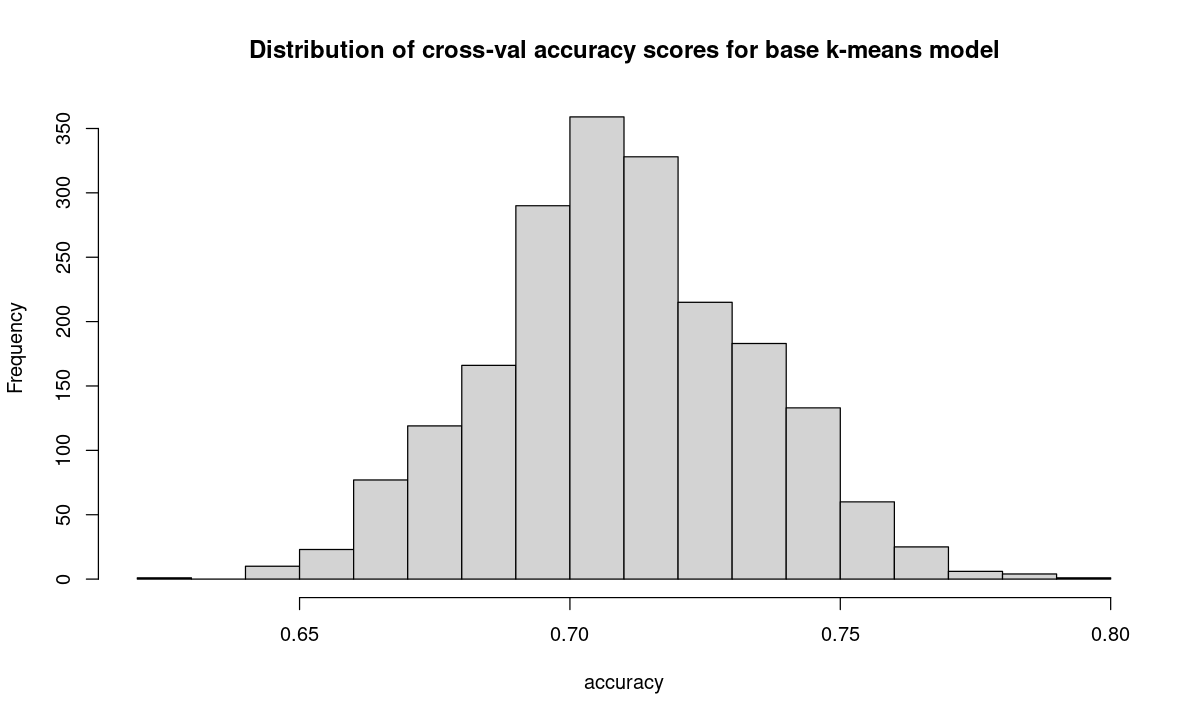

In [122]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(ans$Acc, breaks=16, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for base k-means model")


## First hybrid k-means model

In [128]:
# For the probability columns, use the output from svm02.

preds <- predict(svm02, newdata=svm_scaled, scale=FALSE, probability=TRUE)
prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
round(head(prob01), 3)
round(head(prob02), 3)


[1] 0.014 0.721 0.001 0.752 0.863 0.965

[1] 0.020 0.051 0.919 0.011 0.002 0.000

In [127]:
str(prob01)


 num [1:178] 0.0143 0.7209 0.0013 0.7522 0.8629 ...


In [129]:
df <- train

df$prob01 <- prob01
df$prob02 <- prob02

df02 <- scale(df[, -1], center=TRUE, scale=TRUE)
df_scaled <- apply(as.matrix(df02), MARGIN=2, range01)
df_scaled <- as.data.frame(cbind(df$Type, df_scaled),
                           row.names=rownames(df))
colnames(df_scaled) <- colnames(df)
summary(df_scaled[, -1])


      Hue           Phenols        Alcalinity        prob01       
 Min.   :0.000   Min.   :0.000   Min.   :0.000   Min.   :0.00000  
 1st Qu.:0.246   1st Qu.:0.263   1st Qu.:0.340   1st Qu.:0.00468  
 Median :0.394   Median :0.474   Median :0.459   Median :0.02751  
 Mean   :0.388   Mean   :0.453   Mean   :0.459   Mean   :0.27161  
 3rd Qu.:0.520   3rd Qu.:0.628   3rd Qu.:0.562   3rd Qu.:0.56923  
 Max.   :1.000   Max.   :1.000   Max.   :1.000   Max.   :1.00000  
     prob02       
 Min.   :0.00000  
 1st Qu.:0.00744  
 Median :0.18072  
 Mean   :0.35828  
 3rd Qu.:0.77070  
 Max.   :1.00000  

In [130]:
# Run k-means with number of clusters set to 3.

set.seed(1233)
fit_km <- kmeans(df_scaled[, -1], 3, iter.max = 50, nstart = 30)
print(fit_km$size)


[1] 68 59 51


In [131]:
datout <- as.data.frame(cbind(df_scaled$Type, fit_km$cluster))
colnames(datout) <- c("Type", "cluster")
rownames(datout) <- rownames(df_scaled)
head(datout)


,Type,cluster
,<dbl>,<dbl>
113,2,2
159,3,3
21,1,1
131,3,3
137,3,3
133,3,3


In [132]:
# Map cluster to Type level.

table(datout$Type, as.factor(datout$cluster))


   
     1  2  3
  1 55  4  0
  2 13 52  6
  3  0  3 45

In [133]:
tmpdat <- datout
tmpdat[which(tmpdat$cluster== 1),]$Type <- 1
tmpdat[which(tmpdat$cluster== 2),]$Type <- 2
tmpdat[which(tmpdat$cluster== 3),]$Type <- 3
dim(tmpdat)


[1] 178   2

In [134]:
# Generate confusion matrix for the k-means clusters.

preds <- as.factor(tmpdat$Type)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, df_scaled[, "Type", drop=FALSE])
print(ans$matrix)
''
print(paste("Accuracy score for the hybrid k-means model: ", as.character(ans[[2]]), sep=""))
# 0.8539


   1  2  3 class.error
1 55  4  0      0.0678
2 13 52  6      0.2676
3  0  3 45      0.0625


[1] ""

[1] "Accuracy score for the hybrid k-means model: 0.8539"


## Get comparative cross-val score for the hybrid model

In [135]:
# Function for obtaining average of confusion matrix accuracy
# score. This function is called from compute_cvScore_km.

get_cvScore_hybrid <- function(traindat, valdat) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    
    #############################
    # Scale training set data for the k-means model.
    
    df <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(df, "scaled:center")
    scales <- attr(df, "scaled:scale")
    df <- as.matrix(df)
    # Move the scaled data between 0 and 1.
    traindat_scaled <- apply(df, MARGIN=2, range01)
    colnames(traindat_scaled) <- colnames(traindat)[-1]
    rownames(traindat_scaled) <- rownames(traindat)
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(df, MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(df, MARGIN=2, max))
    
    
    ############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(attr(preds01_b, "probabilities")[, 3])

    
    # Scale valdat.
    df02 <- scale(valdat[, -1], center=centers, scale=scales)
    df02_t <- t(as.matrix(df02))
    df02_asList <- split(df02_t, seq(nrow(df02_t)))
    names(df02_asList) <- colnames(valdat)[-1]
    # Applying min-max scaling here:
    valdat_scaled <- mapply(range02, df02_asList, traindat_mins, 
                            traindat_maxs)
    # The next step is crucial.
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(valdat)[-1]
    
    
    #############################
    # Construct k-means model.

    kmod <- kmeans(traindat_scaled, 3, iter.max = 50, nstart=30)
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster))
    colnames(dfout) <- c("Type", "cluster")
    rownames(dfout) <- rownames(traindat)
    mapping <- get_mapping(dfout)
    
    #############################
    # Apply the k-means model to valdat_scaled.
    
    # Each element of the following list is a row of valdat_scaled.
    valdat_asList <- split(valdat_scaled[, colnames(kmod$centers)],
                           seq(nrow(valdat_scaled)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_scaled$cluster <- as.numeric(cluster_assgns)
    
    valdat_scaled$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_scaled[which(valdat_scaled$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_scaled[which(valdat_scaled$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_scaled[which(valdat_scaled$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_scaled$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [141]:
# Use the same initial seed as we have been using for
# this score.

set.seed(1931)
seed_vector <- sample(1:9999, 2000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_km(seed_vector, train)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6.83 mins


[1] "Start time: 2021-05-30 08:43:33"

Time difference of 6.83 mins

In [142]:
summary(ans$Acc)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.775   0.821   0.831   0.830   0.837   0.860 

In [143]:
round(mean(ans$Acc), 4)
# 0.8295

# For svm02, this score was 0.8278.


[1] 0.8295

In [144]:
round(median(ans$Acc), 4)
round(sd(ans$Acc), 6)
# median: 0.8314
# sd: 0.012021


[1] 0.8314

[1] 0.012021

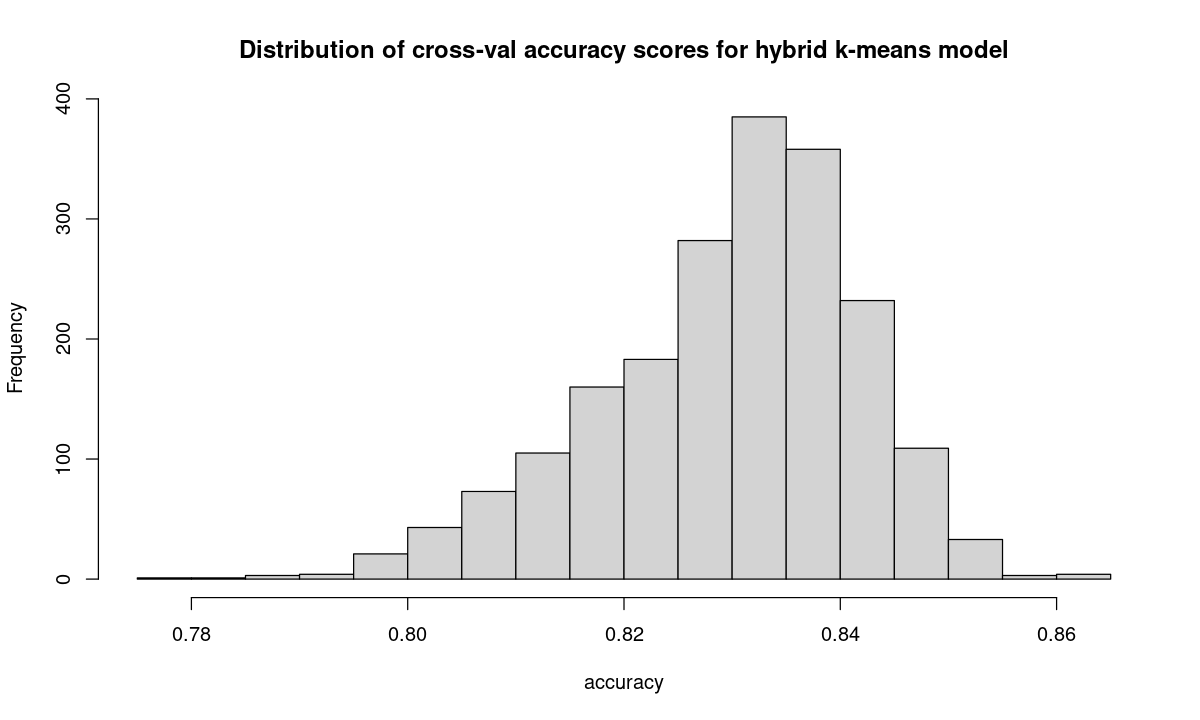

In [145]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(ans$Acc, breaks=14, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for hybrid k-means model")


In [ ]:
### COMMENT:

# At this point we already have a better model than our 
# previous best model, svm02.  The difference in means
# is 0.0017.  This yields an F-statistic of 4.34, giving 
# us a two-tailed p-value of 1.42e-05.
# The difference in median cross-val accuracy scores is
# 0.0043.

# On average, the hybrid model would misclassify 30.35 of
# 178 new records.  svm02  would misclassify 30.65 of the
# 178 new records.  While the improvement in the accuracy
# score is small, it is real and shows that the k-means
# algorithm does have something to add to the modeling.
# In Parts 1 and 2 we saw around a 3% improvement in the 
# accuracy score, but there the number we had to beat was
# around 70%, not the nearly 83% score we are trying to
# beat here.  Also, in this example we are working with
# less than half of the records of the cow data.


# Section 3: Hybrid k-means model with weights

### Find the best weights for the above hybrid model

We find the best weights using cross-validation.  We then get the comparative cross-val score that we need.  We expect to get a slightly better score than what we have already seen.

In [43]:
# Function for obtaining average of confusion matrix 
# accuracy score. This function is called from gridSearch03.

get_cvScore_kmWghts <- function(traindat, valdat, wghts) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    #############################
    # Scale training set data for the k-means model.
    
    df <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(df, "scaled:center")
    scales <- attr(df, "scaled:scale")
    df <- as.matrix(df)
    traindat_scaled <- apply(df, MARGIN=2, range01)
    colnames(traindat_scaled) <- colnames(traindat)[-1]
    rownames(traindat_scaled) <- rownames(traindat)
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(df, MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(df, MARGIN=2, max))
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    
    
    #############################################
    # Prepare valdat.
    #############################################
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(attr(preds01_b, "probabilities")[, 3])

    # Scale valdat.
    df02 <- scale(valdat[, -1], center=centers, scale=scales)
    df02_t <- t(as.matrix(df02))
    df02_asList <- split(df02_t, seq(nrow(df02_t)))
    names(df02_asList) <- colnames(valdat)[-1]

    valdat_scaled <- mapply(range02, df02_asList, traindat_mins, 
                            traindat_maxs)
    # The next step is crucial.
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(valdat)[-1]
    
    # Apply weights to valdat_scaled.
    df4 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df4, row.names=rownames(valdat))
    
    
    #############################################
    # Construct k-means model.

    kmod <- kmeans(traindat_wghts, 3, iter.max = 50, nstart=30)
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster), 
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Type", "cluster")
    mapping <- get_mapping(dfout)
    
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_wghts[which(valdat_wghts$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_wghts[which(valdat_wghts$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_wghts[which(valdat_wghts$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [17]:
# This grid search searches for the best set of weights to use
# in our k-means hybrid model.  The best weights are those
# which generalize best to the validation set.  So we look for
# the best cross-validation accuracy score.
# Because our training set is so small---only 178 records---we
# need to run the gridSearch over many seeds.  Otherwise, we 
# will not get a meaningful result.

gridSearch03 <- function(seed_vector, dat, df_params, folds=5) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "Acc")
    datout$row <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    params_rows <- rownames(df_params)
    
    #############################
    # Partition the data into folds.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are accuracy 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores)
    colnames(df_scores) <- rownames(df_params)
    rownames(df_scores) <- as.character(seed_vector)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(i in 1:folds) {
            endpt <- startpt + segmentsv[i] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[i]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            train_list <- test_list <- vector("list", length= folds)
        
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            ### Do NOT use multiple cores if xgboost is used.
            scores <- mcmapply(get_cvScore_hybrid_pcaWghts, train_list, test_list,
                               MoreArgs= list(wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=5)
            
            # For the current seed, store the average of the accuracy
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the accuracy scores
    # obtained for each set of parameters in df_params.
    datout$Acc <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


In [148]:
# There are 5 parameter lists to work with.  Start by 
# exploring the region around the space where all 
# parameters have an equal weight---in this case, a 
# weight of 0.20.

lst <- vector("list", length= 5)
names(lst) <- c(colnames(train)[-1], "prob01","prob02")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- lst[[5]] <- seq(0.10, 0.30, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  8,801     5


[1] 8801    5

In [149]:
# Work with a random sample of 1000 from dfc01.  Because
# we are looking at only around 11% of the 8,801 records,
# we might not find the best set of weights among these
# 8,801 records.

set.seed(42)
smp <- sample(rownames(dfc01), 1000, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


,Hue,Phenols,Alcalinity,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47656,0.16,0.28,0.26,0.14,0.16
94566,0.28,0.20,0.10,0.20,0.22
26846,0.20,0.28,0.12,0.28,0.12
10006,0.22,0.24,0.20,0.24,0.10
136376,0.26,0.10,0.20,0.16,0.28
73086,0.12,0.10,0.30,0.30,0.18


In [153]:
# Find the best weights of those in tst_params.
# Use 11 seeds.

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch03(seed_vector, train, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 37.75 mins


Time difference of 37.75 mins

In [154]:
summary(dat_result$Acc)

# The interquartile range is about 0.004.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.816   0.823   0.825   0.825   0.827   0.833 

In [155]:
# If we have only a small amount of variance in the 
# resulting accuracy scores, then weights are likely
# not worth the trouble.  [* What I don't know at 
# this point is what is "small" and what is "large".
# It turns out I will need much more variance than
# 0.00235 in order for weights to make a difference
# in the cross-val accuracy score measured over 
# 2000 folds. *]

round(sd(dat_result$Acc), 5)
# 0.00235


[1] 0.00235

In [156]:
dat01 <- dat_result
dat01 <- dat01[order(dat01$Acc, decreasing=TRUE),]
dat01[1:15,]


,row,Acc
,<chr>,<dbl>
917,41936,0.83262
510,83046,0.83167
704,68186,0.83165
524,72166,0.83108
430,73916,0.83057
819,155896,0.83054
726,65866,0.83010
749,28266,0.83006
995,150556,0.83004


In [157]:
bestrows <- as.character(dat01$row)[1:10]
acc <- dat01[1:10, c("Acc")]
dat02 <- cbind(dfc01[bestrows, ], acc)
dat02


,Hue,Phenols,Alcalinity,prob01,prob02,acc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41936,0.16,0.22,0.20,0.28,0.14,0.83262
83046,0.22,0.16,0.18,0.24,0.20,0.83167
68186,0.24,0.20,0.14,0.24,0.18,0.83165
72166,0.20,0.18,0.14,0.30,0.18,0.83108
73916,0.22,0.28,0.20,0.10,0.20,0.83057
155896,0.16,0.18,0.12,0.24,0.30,0.83054
65866,0.26,0.16,0.20,0.20,0.18,0.83010
28266,0.22,0.22,0.14,0.30,0.12,0.83006
150556,0.28,0.14,0.12,0.16,0.30,0.83004


In [ ]:
### COMMENT:

# Use weights in row 41936: 16, 22, 20, 28, 14.


In [158]:
# Refine search.

lst <- vector("list", length= 5)
names(lst) <- c(colnames(train)[-1], "prob01","prob02")

lst[[1]] <- seq(0.15, 0.17, by=0.01)
lst[[2]] <- seq(0.20, 0.24, by=0.01)
lst[[3]] <- seq(0.18, 0.21, by=0.01)
lst[[4]] <- seq(0.27, 0.31, by=0.01)
lst[[5]] <- seq(0.12, 0.19, by=0.01)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  235     5


[1] 235   5

In [159]:
# Find the best weights of those in dfc02 (235 rows,
# 11 seeds, 5 folds).  

set.seed(1981)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch03(seed_vector, train, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 8.52 mins


[1] "Start time: 2021-05-30 10:22:31"

Time difference of 8.52 mins

In [160]:
best_params <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$row
length(best_params)

best_Acc <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$Acc


[1] 1

In [161]:
dfc02[best_params,]
#       	 Hue 	 Phenols 	 Alcalinity 	prob01  	prob02

# 684   	0.17    	0.22 	       0.19 	  0.28  	  0.14


,Hue,Phenols,Alcalinity,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
684,0.17,0.22,0.19,0.28,0.14


In [162]:
best_Acc
# 0.8349


[1] 0.83494

In [163]:
dat01 <- dat_result
dat01 <- dat01[order(dat01$Acc, decreasing=TRUE),]
dat01[1:15,]


,row,Acc
,<chr>,<dbl>
98,684,0.83494
134,914,0.83446
174,1211,0.83446
188,1280,0.83440
152,997,0.83345
141,948,0.83342
194,1325,0.83337
176,1221,0.83336
191,1294,0.83336


In [164]:
bestrows <- as.character(dat01$row)[1:6]
acc <- dat01[1:6, c("Acc")]
dat02 <- cbind(dfc02[bestrows, ], acc)
dat02


,Hue,Phenols,Alcalinity,prob01,prob02,acc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
684,0.17,0.22,0.19,0.28,0.14,0.83494
914,0.16,0.24,0.18,0.27,0.15,0.83446
1211,0.16,0.23,0.18,0.27,0.16,0.83446
1280,0.16,0.21,0.19,0.28,0.16,0.83440
997,0.15,0.22,0.20,0.28,0.15,0.83345
948,0.17,0.20,0.21,0.27,0.15,0.83342


In [181]:
# Find the best weights of those in dat02 (6 rows,
# 1000 seeds, 5 folds).
### NOTE: Before running the following, I should 
### have added rep(0.20, 5) to dat02 to compare
### the above weight combinations with no weights.

set.seed(1931)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch03(seed_vector, train, dat02[, 1:5]) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 20.42 mins


[1] "Start time: 2021-05-30 11:19:42"

Time difference of 20.42 mins

In [182]:
dat_result[order(dat_result$Acc, decreasing=TRUE),]


,row,Acc
,<chr>,<dbl>
4,1280,0.82947
1,684,0.82931
6,948,0.82923
5,997,0.82907
3,1211,0.82896
2,914,0.82874


In [183]:
best_params <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$row
length(best_params)

best_Acc <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$Acc


[1] 1

In [184]:
dat02[best_params, 1:5]
#       	 Hue 	 Phenols 	 Alcalinity 	prob01  	prob02

# 1280  	0.16    	0.21 	       0.19 	  0.28  	  0.16


best_Acc
# 0.8295


,Hue,Phenols,Alcalinity,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1280,0.16,0.21,0.19,0.28,0.16


[1] 0.82947

## Get comparative cross-val score for the hybrid model with weights

In [192]:
# Function for obtaining average of confusion matrix 
# accuracy score. This function is called from compute_cvScore_km.

# We need to take the square root of the weights.
wghts <- c(0.16, 0.21, 0.19, 0.28, 0.16)^0.5
names(wghts) <- c(colnames(train)[-1], "prob01","prob02")

get_cvScore_wghts <- function(traindat, valdat) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    #############################
    # Scale training set data for the k-means model.
    
    df <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(df, "scaled:center")
    scales <- attr(df, "scaled:scale")
    df <- as.matrix(df)
    traindat_scaled <- apply(df, MARGIN=2, range01)
    colnames(traindat_scaled) <- colnames(traindat)[-1]
    rownames(traindat_scaled) <- rownames(traindat)
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(df, MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(df, MARGIN=2, max))
    
    #############################
    # Apply weights to traindat.
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    
    
    #############################################
    # Prepare valdat.
    #############################################
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(attr(preds01_b, "probabilities")[, 3])

    # Scale valdat.
    df02 <- scale(valdat[, -1], center=centers, scale=scales)
    df02_t <- t(as.matrix(df02))
    df02_asList <- split(df02_t, seq(nrow(df02_t)))
    names(df02_asList) <- colnames(valdat)[-1]

    valdat_scaled <- mapply(range02, df02_asList, traindat_mins, 
                            traindat_maxs)
    # The next step is crucial.
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(valdat)[-1]
    
    # Apply weights to valdat_scaled.
    df4 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df4, row.names=rownames(valdat))
    colnames(valdat_wghts) <- colnames(valdat)[-1]
    
    
    #############################################
    # Construct k-means model.

    kmod <- kmeans(traindat_wghts, 3, iter.max = 50, nstart=30)
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster), 
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Type", "cluster")
    mapping <- get_mapping(dfout)
    
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_wghts[which(valdat_wghts$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_wghts[which(valdat_wghts$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_wghts[which(valdat_wghts$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [208]:
# Use the correct seed, i.e., the seed we have been
# using for this comparative score.

set.seed(1931)
seed_vector <- sample(1:9999, 2000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- compute_cvScore_km(seed_vector, train) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6.71 mins


[1] "Start time: 2021-05-30 12:09:57"

Time difference of 6.54 mins

In [209]:
summary(dat_result$Acc)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.780   0.821   0.831   0.829   0.837   0.860 

In [210]:
round(mean(dat_result$Acc), 4)

# Accuracy over 2000 seeds is 0.8292.  Without weights,
# this score was 0.8295.  svm02 had an average
# cross-val accuracy score of 0.8278.

# One thing this shows is that I need far more than 11
# seeds (giving us 55 folds) in the initial search for
# weights.  But if I were to use many more seeds, the
# search would take far more time.  It would also help to
# look at some of the 7,800 weight combinations that were
# not included in the 1000 that were in my sample.


[1] 0.8292

In [211]:
round(median(dat_result$Acc), 4)
round(sd(dat_result$Acc), 6)
# median: 0.8310
# sd: 0.012081

# The median accuracy score for svm02 was 0.8271.
# Without weights, the hybrid model had a median
# accuracy score of 0.8314.


[1] 0.831

[1] 0.012081

In [212]:
head(dat_result)
dim(dat_result)


,seed,Acc
,<int>,<dbl>
1,6276,0.83238
2,8252,0.82058
3,6728,0.83104
4,9082,0.84316
5,7952,0.82550
6,8360,0.84280


[1] 2000    2

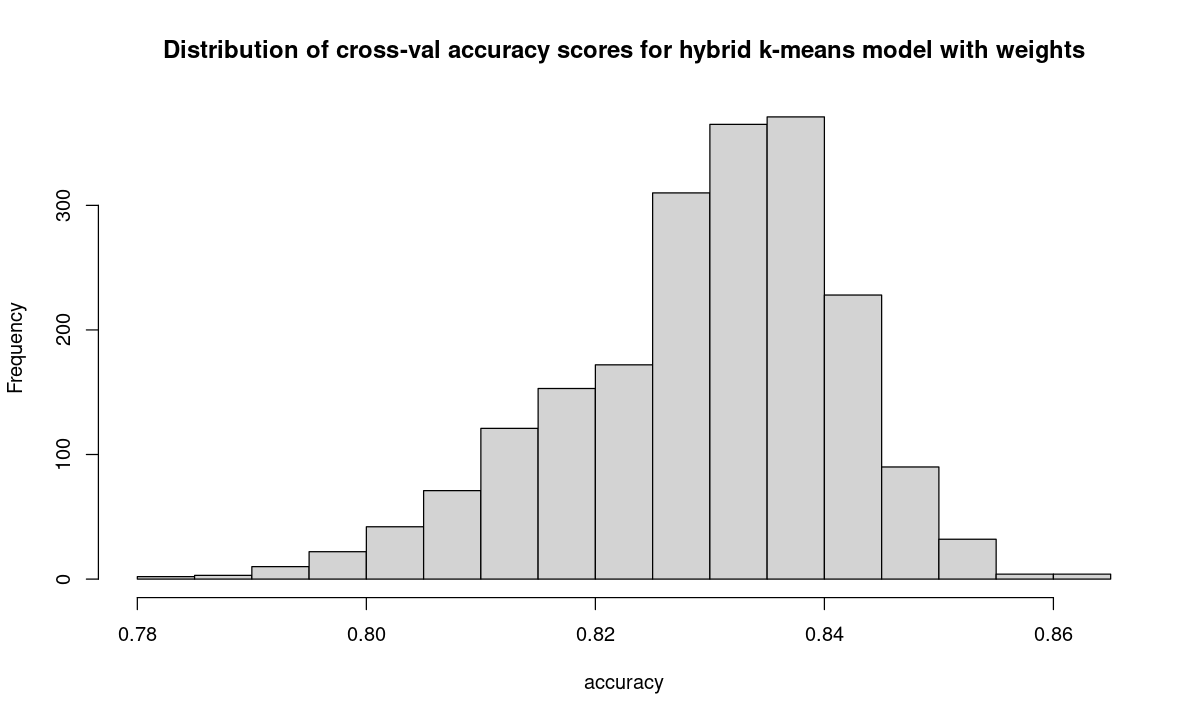

In [213]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Acc, breaks=16, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for hybrid k-means model with weights")


## Section 3: Final Comments

We should be able to improve upon the hybrid model that does not use weights, especially given that the standard deviation over the 1000 weight combinations looked at above is 0.00235.  Our cross-val mean accuracy score for the hybrid model with no weights is 0.8295.  I would expect to see around 1 standard deviation of improvement on this.  So we should be able to get a score as high as 0.8318 with appropriate weights.  The 0.8318 score would give us a 0.4 percentage point improvement over the svm02 model; while this isn't much, it is better than the 0.17 percentage point improvement that we are currently seeing with the hybrid model, no weights.

Finding good weights is not easy from a computational standpoint.  It looks like I need to test each weight combination on far more seeds (the different seeds give us different partitions of the 178 records, i.e., different cross-val folds).  It would also be good to look at all of the 8,801 combinations in the above dfc01 dataframe.  It is worth trying the method I used in the Addendum of Part 2, a method that looks at the total within-group sum of squares of the different k-means clusterings.  In Part 2, this alternative method of finding weights was 7X faster than the method I have been using.  (The improvement in speed depends on what we are trying to do with the data and the amount of data we are working with.)


                                * * * * *

# Section 4: Hybrid model with weights found using total withinss

The method of finding weights set out in the Addendum of Part 2 is not guaranteed to work.  But it is worth trying out here, in our initial search for weights, when we have the most weight combinations to look through.

This alternative approach to finding weights acquires further validation if we can find a set of weights using the method which improve upon our cross-val mean accuracy score of 0.8295.

This alternative approach is faster because: (a) we no longer have to call getCluster; (b) we no longer have to apply weights to the training set data; (c) we no longer have to call get_mapping; and (d) we no longer have to apply min-max scaling to the training set.  Of these three operations, (a) and (c) are the more expensive ones.


In [16]:
# Function for computing the tot.withinss for each set of 
# weights in df_params (a dataframe, each row of which is
# a candidate set of weights).  The optimal set of weights
# will be the set that yields the smallest average (over
# the folds) for tot.withinss.
# This function is called from gridSearch07.

get_tot.withinss <- function(traindat, valdat, wghts) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    #############################
    # Scale training set data for the k-means model.
    
    df <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(df, "scaled:center")
    scales <- attr(df, "scaled:scale")
    df <- as.matrix(df)
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(df, MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(df, MARGIN=2, max))
    

    #############################################
    # Prepare valdat.
    #############################################
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(attr(preds01_b, "probabilities")[, 3])

    # Scale valdat.
    df02 <- scale(valdat[, -1], center=centers, scale=scales)
    df02_t <- t(as.matrix(df02))
    df02_asList <- split(df02_t, seq(nrow(df02_t)))
    names(df02_asList) <- colnames(valdat)[-1]

    valdat_scaled <- mapply(range02, df02_asList, traindat_mins, 
                            traindat_maxs)
    # The next step is crucial.
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(valdat)[-1]
    
    # Apply weights to valdat_scaled.
    cols <- names(wghts)
    df4 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df4, row.names=rownames(valdat))
    colnames(valdat_wghts) <- colnames(valdat)[-1]
    
    
    #############################################
    # Construct k-means model on the validation set.

    kmod <- kmeans(valdat_wghts, 3, iter.max = 50, nstart=30)
    
    return(kmod$tot.withinss)
}


In [73]:
# This grid search searches for the best set of weights to use
# in our k-means clustering model. 

gridSearch07 <- function(seed_vector, dat, df_params, folds=5) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "tot.withinss")
    datout$row <- params_rows <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    
    #############################
    # Partition the data into folds.
    
    segment_size <- round(dim(dat)[1]/folds)
    diff <- dim(dat)[1] - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == dim(dat)[1])
    
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are tot.withinss 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores)
    colnames(df_scores) <- rownames(df_params)
    rownames(df_scores) <- as.character(seed_vector)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(i in 1:folds) {
            endpt <- startpt + segmentsv[i] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[i]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            
            train_list <- test_list <- vector("list", length= folds)
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            # When there are only 5 folds, only 5 cores get used.
            scores <- mcmapply(get_tot.withinss02, train_list, test_list,
                               MoreArgs= list(wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=5)
            
            # For the current seed, store the average of the tot.withinss
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the tot.withinss scores
    # obtained for each set of parameters in df_params.
    datout$tot.withinss <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


In [18]:
# There are 5 parameter lists to work with.  Start by 
# exploring the region around the space where all 
# parameters have an equal weight---in this case, a 
# weight of 0.20.

lst <- vector("list", length= 5)
names(lst) <- c(colnames(train)[-1], "prob01","prob02")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- lst[[5]] <- seq(0.10, 0.30, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  8,801     5


[1] 8801    5

In [24]:
# Test on a sample of 100.

set.seed(42)
smp <- sample(rownames(dfc01), 100, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


,Hue,Phenols,Alcalinity,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47656,0.16,0.28,0.26,0.14,0.16
94566,0.28,0.20,0.10,0.20,0.22
26846,0.20,0.28,0.12,0.28,0.12
10006,0.22,0.24,0.20,0.24,0.10
136376,0.26,0.10,0.20,0.16,0.28
73086,0.12,0.10,0.30,0.30,0.18


In [25]:
# Find the best weights of those in tst_params.
# Use 120 seeds.

set.seed(1233)
seed_vector <- sample(1:9999, 120, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch07(seed_vector, train, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 7.82 mins (for 100 rows; 120 seeds each row)


Time difference of 7.82 mins

In [26]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [27]:
dfc01[best_params,]

best_tot.withinss


,Hue,Phenols,Alcalinity,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
145126,0.14,0.18,0.1,0.3,0.28


[1] 0.55

In [ ]:
### COMMENT:

# I will search 5000 of the 8801 weight combinations.  This 
# should take approximately 6.5 hours.


In [28]:
set.seed(42)
smp <- sample(rownames(dfc01), 5000, replace=FALSE)
tst_params <- dfc01[smp,]
remaining <- dfc01[which(!(rownames(dfc01) %in% rownames(tst_params))),]
dim(remaining)


[1] 3801    5

In [29]:
save(remaining, file="/home/greg/Documents/stat/github_repos/nudging_kmeans/untested_weights.Rdata")


In [30]:
# Find the best weights of those in tst_params.
# Use 120 seeds.

set.seed(1233)
seed_vector <- sample(1:9999, 120, replace=FALSE)

start <- Sys.time()
paste0("Start time: ", start)
dat_result <- gridSearch07(seed_vector, train, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 7.93 hours (for 5000 rows; 120 seeds each row)


Time difference of 7.93 hours

In [31]:
save(dat_result, file="/home/greg/Documents/stat/github_repos/nudging_kmeans/processed_weights.Rdata")


In [34]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 5)


[1] 1

In [35]:
dfc01[best_params,]
#       	Hue 	Phenols 	 Alcalinity  	 prob01 	 prob02

# 159776	0.1     	0.2         	0.1     	0.3     	0.3


best_tot.withinss
# 0.5428


,Hue,Phenols,Alcalinity,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
159776,0.1,0.2,0.1,0.3,0.3


[1] 0.5428

In [36]:
dat01 <- dat_result[order(dat_result$tot.withinss, decreasing=FALSE),]
dat01[1:15,]


,row,tot.withinss
,<chr>,<dbl>
2071,159776,0.54280
2384,159756,0.54420
3975,159766,0.54421
1615,145146,0.54453
939,153176,0.54456
2008,157126,0.54492
3441,159886,0.54503
4654,139866,0.54511
515,151846,0.54563


In [37]:
bestrows <- as.character(dat01$row)[1:10]
withinss.vals <- dat01[1:10, c("tot.withinss")]
dat01_b <- cbind(dfc01[bestrows, ], withinss.vals)
dat01_b


,Hue,Phenols,Alcalinity,prob01,prob02,withinss.vals
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
159776,0.10,0.20,0.10,0.30,0.30,0.54280
159756,0.14,0.16,0.10,0.30,0.30,0.54420
159766,0.12,0.18,0.10,0.30,0.30,0.54421
145146,0.10,0.22,0.10,0.30,0.28,0.54453
153176,0.10,0.30,0.10,0.20,0.30,0.54456
157126,0.12,0.22,0.10,0.26,0.30,0.54492
159886,0.10,0.18,0.12,0.30,0.30,0.54503
139866,0.10,0.30,0.10,0.22,0.28,0.54511
151846,0.12,0.30,0.10,0.18,0.30,0.54563


In [ ]:
### COMMENTS:

# The best weights identified are almost all at the limits
# of the tested parameter space: 0.10 was the smallest 
# possible value, and 0.30 was the largest.  Thus, we
# might see even smaller total withinss in regions that
# have yet to be tested.


In [41]:
# Refine the search a bit.

lst <- vector("list", length= 5)
names(lst) <- c(colnames(train)[-1], "prob01","prob02")

lst[[1]] <- seq(0.08, 0.12, by=0.01)
lst[[2]] <- seq(0.18, 0.22, by=0.01)
lst[[3]] <- seq(0.08, 0.12, by=0.01)
lst[[4]] <- seq(0.28, 0.34, by=0.01)
lst[[5]] <- seq(0.28, 0.34, by=0.02)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  8,801     5


[1] 309   5

In [42]:
# Add in the no-weights combination.

dfc02 <- rbind(dfc02, rep(0.20, 5))
dim(dfc02)


[1] 310   5

In [45]:
# Find the best weights of those in dfc02.
# Use 120 seeds.  Use gridSearch03.

set.seed(1987)
seed_vector <- sample(1:9999, 120, replace=FALSE)

start <- Sys.time()
paste0("Start time: ", start)
dat_result <- gridSearch03(seed_vector, train, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.11 hours

# This time difference tells us that for this 178 record
# dataset, the alternative method of finding weights is
# 5.2X faster.


[1] "Start time: 2021-06-01 09:12:07"

Time difference of 2.11 hours

In [48]:
round(sd(dat_result$Acc), 4)
# 0.0005

round((max(dat_result$Acc) - min(dat_result$Acc)), 4)
# 0.0027


[1] 5e-04

[1] 0.0027

In [ ]:
### COMMENT:

# Note the low standard deviation for the 310 weight 
# combinations and the low range.  Our "no weights"
# combination is among the 310.  


In [49]:
best_params <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$row
length(best_params)

best_Acc <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$Acc


[1] 2

In [50]:
dfc02[best_params,]
#       	 Hue 	 Phenols 	 Alcalinity 	prob01  	prob02

# 515   	0.12    	0.20 	       0.08 	  0.32  	  0.28


,Hue,Phenols,Alcalinity,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
515,0.12,0.20,0.08,0.32,0.28
1284,0.11,0.19,0.09,0.31,0.30


In [51]:
dat02 <- dat_result[order(dat_result$Acc, decreasing=TRUE),]
dat02[1:10,]


,row,Acc
,<chr>,<dbl>
50,515,0.83110
159,1284,0.83110
46,479,0.83107
69,635,0.83088
261,2161,0.83086
192,1532,0.83082
205,1773,0.83080
308,3026,0.83080
20,315,0.83079


In [52]:
bestrows <- as.character(dat02$row)[1:3]
acc <- dat02[1:3, c("Acc")]
dat02_b <- cbind(dfc02[bestrows, ], acc)
dat02_b


,Hue,Phenols,Alcalinity,prob01,prob02,acc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
515,0.12,0.20,0.08,0.32,0.28,0.83110
1284,0.11,0.19,0.09,0.31,0.30,0.83110
479,0.11,0.18,0.12,0.31,0.28,0.83107


In [67]:
tail(dfc02)


,Hue,Phenols,Alcalinity,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2926,0.08,0.18,0.10,0.30,0.34
3002,0.09,0.18,0.08,0.31,0.34
3006,0.08,0.19,0.08,0.31,0.34
3026,0.08,0.18,0.09,0.31,0.34
3126,0.08,0.18,0.08,0.32,0.34
310,0.20,0.20,0.20,0.20,0.20


In [68]:
dat02["310", c("Acc")]


[1] 0.83022

In [ ]:
### COMMENT:

# Over 120 seeds (600 folds), the current best weights
# have a score of 0.83110 and the "no-weights" model
# has a score of 0.83022.  This is a difference of 
# 8.8e-04.  In other words, the current best weights
# are not helping much at all to improve the average
# accuracy score of the k-means hybrid model.


In [53]:
# Refine the search.

dfc03 <- dat02_b[, 1:5]


In [54]:
# Find the best weights of those in dfc03.
# Use 1200 seeds.  Use gridSearch03.

set.seed(1981)
seed_vector <- sample(1:9999, 1200, replace=FALSE)

start <- Sys.time()
paste0("Start time: ", start)
dat_result <- gridSearch03(seed_vector, train, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 12.49 mins


[1] "Start time: 2021-06-01 11:50:04"

Time difference of 12.49 mins

In [55]:
best_params <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$row
length(best_params)

best_Acc <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$Acc


[1] 1

In [56]:
dat03 <- dat_result[order(dat_result$Acc, decreasing=TRUE),]
dat03


,row,Acc
,<chr>,<dbl>
3,479,0.83024
1,515,0.83002
2,1284,0.82997


In [57]:
bestrows <- as.character(dat03$row)
acc <- dat03[, c("Acc")]
dat03_b <- cbind(dfc03[bestrows, ], acc)
dat03_b


,Hue,Phenols,Alcalinity,prob01,prob02,acc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
479,0.11,0.18,0.12,0.31,0.28,0.83024
515,0.12,0.20,0.08,0.32,0.28,0.83002
1284,0.11,0.19,0.09,0.31,0.30,0.82997


In [ ]:
### COMMENT:

# As the number of seeds increases, the average
# accuracy score decreases toward the 0.8295 
# number we are trying to beat. The 0.8295 number
# is from the hybrid model without weights.  It 
# may be that the scaling I am applying, in combination
# with looking at many thousands of folds of the 
# data (for a data set that is only 178 records),
# lessens the importance of weights.


## Get comparative cross-val score using the new weights

In [58]:
# Function for obtaining average of confusion matrix 
# accuracy score. This function is called from compute_cvScore_km.

# This is the same function as above; only the weights have changed.

# We need to take the square root of the weights.
wghts <- c(0.11, 0.18, 0.12, 0.31, 0.28)^0.5
names(wghts) <- c(colnames(train)[-1], "prob01","prob02")

get_cvScore_wghts <- function(traindat, valdat) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    #############################
    # Scale training set data for the k-means model.
    
    df <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(df, "scaled:center")
    scales <- attr(df, "scaled:scale")
    df <- as.matrix(df)
    traindat_scaled <- apply(df, MARGIN=2, range01)
    colnames(traindat_scaled) <- colnames(traindat)[-1]
    rownames(traindat_scaled) <- rownames(traindat)
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(df, MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(df, MARGIN=2, max))
    
    #############################
    # Apply weights to traindat.
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    
    
    #############################################
    # Prepare valdat.
    #############################################
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(attr(preds01_b, "probabilities")[, 3])

    # Scale valdat.
    df02 <- scale(valdat[, -1], center=centers, scale=scales)
    df02_t <- t(as.matrix(df02))
    df02_asList <- split(df02_t, seq(nrow(df02_t)))
    names(df02_asList) <- colnames(valdat)[-1]

    valdat_scaled <- mapply(range02, df02_asList, traindat_mins, 
                            traindat_maxs)
    # The next step is crucial.
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(valdat)[-1]
    
    # Apply weights to valdat_scaled.
    df4 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df4, row.names=rownames(valdat))
    colnames(valdat_wghts) <- colnames(valdat)[-1]
    
    
    #############################################
    # Construct k-means model.

    kmod <- kmeans(traindat_wghts, 3, iter.max = 50, nstart=30)
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster), 
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Type", "cluster")
    mapping <- get_mapping(dfout)
    
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_wghts[which(valdat_wghts$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_wghts[which(valdat_wghts$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_wghts[which(valdat_wghts$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [60]:
# Use the correct seed, i.e., the seed we have been
# using for this comparative score.

set.seed(1931)
seed_vector <- sample(1:9999, 2000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- compute_cvScore_km(seed_vector, train) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 7.59 mins


[1] "Start time: 2021-06-01 12:06:31"

Time difference of 7.59 mins

In [61]:
summary(dat_result$Acc)

# The interquartile range is 1.6 percentage points.
# For svm02 this range was 1.7 points.
# Both distributions have the same maximum value, to
# 3 significant digits.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.776   0.821   0.831   0.829   0.837   0.866 

In [62]:
round(mean(dat_result$Acc), 4)

# Accuracy over 2000 seeds is 0.8293.  Without weights,
# this score was 0.8295.  svm02 had an average
# cross-val accuracy score of 0.8278.


[1] 0.8293

In [63]:
round(median(dat_result$Acc), 4)
round(sd(dat_result$Acc), 6)
# median: 0.8311
# sd: 0.012282

# The median accuracy score for svm02 was 0.8271.


[1] 0.8311

[1] 0.012282

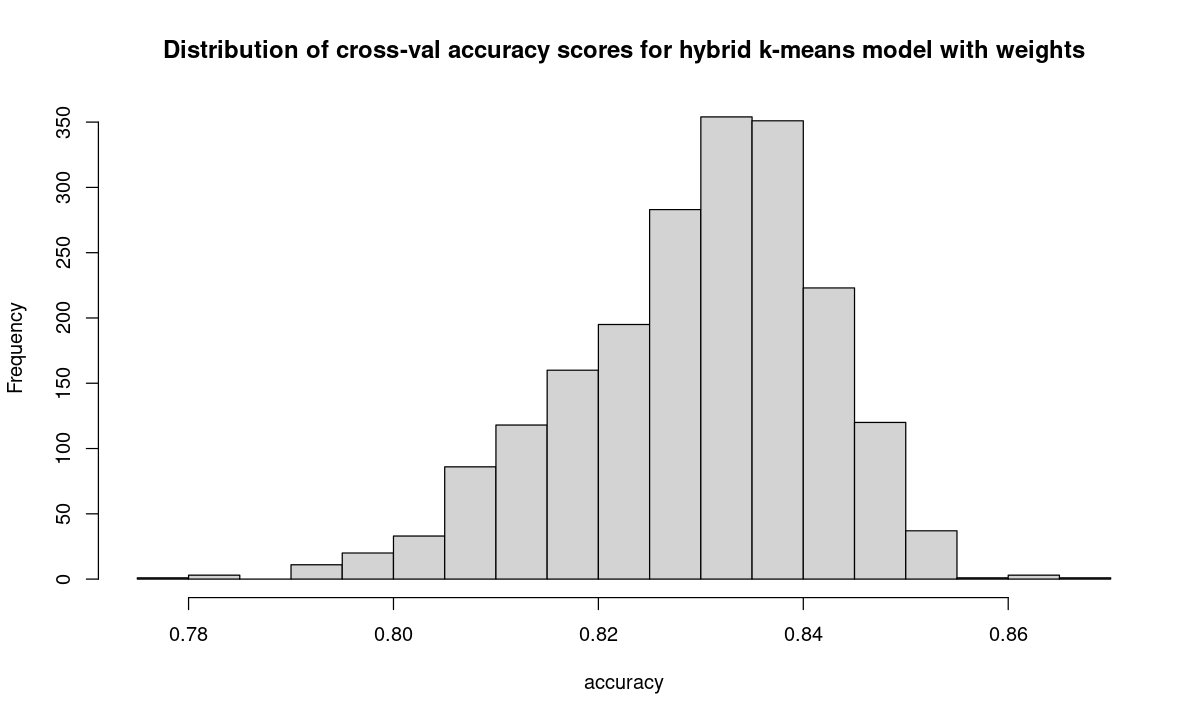

In [65]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Acc, breaks=16, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for hybrid k-means model with weights")


## Section 4 Comments

While I have not done an exhaustive search for weights, current results are showing that weights are not helping to improve the accuracy score when this score is measured over a very large number of seeds, or folds.  In this case, each of the folds is only 35 or 36 records (20% of the data).  We saw the same result, but with a different set of weights, in Section 3---the result being that using weights did not improve upon the original model.  Different weights give us different average accuracy scores on validation data, but these differences disappear as we increase the number of sets of validation data to a very large number---in this case, 2000 times 5, or 10,000 folds (sets).

Although I did not foresee it, this asymptotic-like behavior makes sense.  I was looking for a stable answer regarding best model, overlooking a different kind of consequence of the fact that a model's performance varies no small amount depending on the data that the model is applied to.  If we present each model with enough data, the average performances might not be all that different, especially if---as was the case here--- the type of model is the same in all cases; I was only changing the weights.

Nonetheless, the primary reason for this lack of difference, I suspect, is the scaling I am applying to the data: centering each of the variables, scaling so that each variable has unit variance, and then mapping all values into the range, \[0, 1\].

The alternative method of finding weights, looking for a minimum in tot.withinss (total within group sum of squares), does seem to work, although I am not yet fully convinced.  While the weights I found using this method performed no worse than the weights I found using cross-validation with accuracy scores, we have found that we might be able to say this about any of the sets of weights tested.


# Section 5: Get scores for k-means models, absent min-max scaling

In [14]:
summary(train[, -1])


      Hue           Phenols       Alcalinity  
 Min.   :0.480   Min.   :0.98   Min.   :10.6  
 1st Qu.:0.782   1st Qu.:1.74   1st Qu.:17.2  
 Median :0.965   Median :2.35   Median :19.5  
 Mean   :0.957   Mean   :2.30   Mean   :19.5  
 3rd Qu.:1.120   3rd Qu.:2.80   3rd Qu.:21.5  
 Max.   :1.710   Max.   :3.88   Max.   :30.0  

In [20]:
# Before scaling, transform the data a bit so 
# the variable ranges are more alike in terms
# of range.

df <- train
df$Phenols <- (df$Phenols)^0.5
df$Alcalinity <- (df$Alcalinity)^0.18
summary(df[, -1])


      Hue           Phenols       Alcalinity  
 Min.   :0.480   Min.   :0.99   Min.   :1.53  
 1st Qu.:0.782   1st Qu.:1.32   1st Qu.:1.67  
 Median :0.965   Median :1.53   Median :1.71  
 Mean   :0.957   Mean   :1.50   Mean   :1.70  
 3rd Qu.:1.120   3rd Qu.:1.67   3rd Qu.:1.74  
 Max.   :1.710   Max.   :1.97   Max.   :1.84  

In [21]:
df_scaled <- scale(df[, -1], center=TRUE, scale=TRUE)
df_scaled <- as.data.frame(cbind(df$Type, df_scaled),
                           row.names=rownames(df))
colnames(df_scaled) <- colnames(df)
summary(df_scaled[, -1])


      Hue            Phenols         Alcalinity     
 Min.   :-2.089   Min.   :-2.429   Min.   :-3.2418  
 1st Qu.:-0.765   1st Qu.:-0.858   1st Qu.:-0.6406  
 Median : 0.033   Median : 0.163   Median : 0.0717  
 Mean   : 0.000   Mean   : 0.000   Mean   : 0.0000  
 3rd Qu.: 0.711   3rd Qu.: 0.823   3rd Qu.: 0.6370  
 Max.   : 3.292   Max.   : 2.233   Max.   : 2.6425  

In [22]:
# Run k-means with number of clusters set to 3.

set.seed(1233)
fit_km <- kmeans(df_scaled[, -1], 3, iter.max = 50, nstart = 30)
print(fit_km$size)


[1] 73 59 46


In [18]:
datout <- as.data.frame(cbind(df_scaled$Type, fit_km$cluster))
colnames(datout) <- c("Type", "cluster")
rownames(datout) <- rownames(df_scaled)
head(datout)


,Type,cluster
,<dbl>,<dbl>
113,2,3
159,3,3
21,1,1
131,3,2
137,3,2
133,3,2


In [19]:
# We need to map cluster to Type level.

table(datout$Type, as.factor(datout$cluster))


   
     1  2  3
  1 49  0 10
  2 24 14 33
  3  0 45  3

In [20]:
ans <- as.matrix(table(datout$Type, as.factor(datout$cluster)))
print(apply(ans, MARGIN=2, which.max))


1 2 3 
1 3 2 


In [21]:
# Apply mapping resulting from fit_km above.

tmpdat <- datout
tmpdat[which(tmpdat$cluster== 1),]$Type <- 1
tmpdat[which(tmpdat$cluster== 2),]$Type <- 3
tmpdat[which(tmpdat$cluster== 3),]$Type <- 2


In [23]:
# Generate confusion matrix for the k-means clusters.
# Output accuracy for this confusion matrix.

preds <- as.factor(tmpdat$Type)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, df_scaled[, "Type", drop=FALSE])
print(ans$matrix)
''
print(paste("Accuracy score for the base k-means model: ", as.character(ans[[2]]), sep=""))
# Section 2 base k-means accuracy score on training set: 0.7135

# current accuracy score: 0.7135


   1  2  3 class.error
1 49 10  0      0.1695
2 24 33 14      0.5352
3  0  3 45      0.0625


[1] ""

[1] "Accuracy score for the base k-means model: 0.7135"


## Get comparative cross-val score for this new base k-means model

In [17]:
# Function for obtaining average of confusion matrix 
# accuracy score. This function is called from compute_cvScore_km.

get_cvScore_km02 <- function(traindat, valdat) {
    
    # Scale training set data.  traindat and valdat 
    # columns have already been transformed in the 
    # calling function.
    df <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(df, "scaled:center")
    scales <- attr(df, "scaled:scale")
    # df is a matrix, not a dataframe; this means we 
    # cannot refer to its columns using $

    
    ############################
    # Transform and scale valdat.
    df02 <- scale(valdat[, -1], center=centers, scale=scales)
    
    # The next step is crucial.
    valdat_scaled <- as.data.frame(df02, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(valdat)[-1]
    
    
    #########################
    # Construct k-means model.

    kmod <- kmeans(df, 3, iter.max = 50, nstart=30)
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster))
    colnames(dfout) <- c("Type", "cluster")
    rownames(dfout) <- rownames(traindat)
    mapping <- get_mapping(dfout)
    
    #############################
    # Apply the k-means model to valdat_scaled.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_scaled[, colnames(kmod$centers)],
                           seq(nrow(valdat_scaled)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_scaled$cluster <- as.numeric(cluster_assgns)
    
    valdat_scaled$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_scaled[which(valdat_scaled$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_scaled[which(valdat_scaled$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_scaled[which(valdat_scaled$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_scaled$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [23]:
# Again, use the same initial seed that we have 
# been using for this score.

set.seed(1931)
seed_vector <- sample(1:9999, 2000, replace=FALSE)


# Use df instead of train since df has the variable 
# transformations.

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_km(seed_vector, df)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.26 mins


[1] "Start time: 2021-06-02 10:15:20"

Time difference of 5.26 mins

In [24]:
summary(ans$Acc)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.642   0.692   0.708   0.706   0.719   0.765 

In [25]:
round(mean(ans$Acc), 4)
# 0.7057

# In Section 2 above, using the min-max scaling, our
# score was 0.7095


[1] 0.7057

In [26]:
round(median(ans$Acc), 4)
round(sd(ans$Acc), 6)
# median: 0.7075
# sd: 0.018619


# Section 2 median: 0.7085
# Section 2 sd: 0.024145


[1] 0.7075

[1] 0.018619

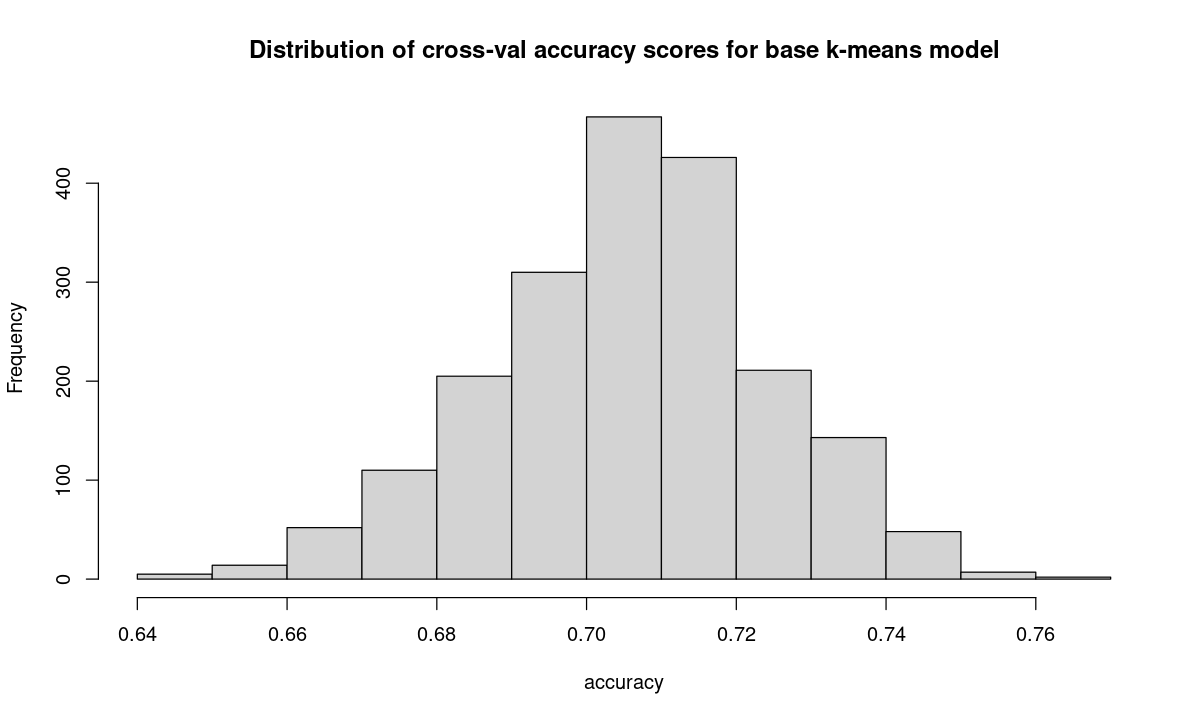

In [27]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(ans$Acc, breaks=16, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for base k-means model")


In [ ]:
### COMMENTS:

# The scores are somewhat better when we use the min-max
# scaling on top of the regular scaling.  Here I applied
# some transformations to the variables and then applied
# regular scaling.  When I did this in Part 2, I then
# found weights and those weights made a real difference
# in the score.  So it is worth looking into whether 
# weights make a difference in this case, too.


## Get comparative cross-val score for the corresponding hybrid model

In [29]:
# Function for obtaining average of confusion matrix accuracy
# score. This function is called from compute_cvScore_km.

get_cvScore_hybrid02 <- function(traindat, valdat) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    # Apply transformations to Phenols and Alcalinity
    traindat$Phenols <- (traindat$Phenols)^0.5
    traindat$Alcalinity <- (traindat$Alcalinity)^0.18
    
    #############################
    # Scale training set data for the k-means model.
    
    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    rownames(traindat_scaled) <- rownames(traindat)
    
    
    ############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(attr(preds01_b, "probabilities")[, 3])
    
    # Apply transformations to Phenols and Alcalinity
    valdat$Phenols <- (valdat$Phenols)^0.5
    valdat$Alcalinity <- (valdat$Alcalinity)^0.18

    # Scale valdat.
    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    
    # The next step is crucial.
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    
    #############################
    # Construct k-means model.

    kmod <- kmeans(traindat_scaled, 3, iter.max = 50, nstart=30)
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster))
    colnames(dfout) <- c("Type", "cluster")
    rownames(dfout) <- rownames(traindat)
    mapping <- get_mapping(dfout)
    
    #############################
    # Apply the k-means model to valdat_scaled.
    
    # Each element of the following list is a row of valdat_scaled.
    valdat_asList <- split(valdat_scaled[, colnames(kmod$centers)],
                           seq(nrow(valdat_scaled)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_scaled$cluster <- as.numeric(cluster_assgns)
    
    valdat_scaled$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_scaled[which(valdat_scaled$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_scaled[which(valdat_scaled$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_scaled[which(valdat_scaled$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_scaled$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [30]:
# Use the same initial seed as we have been using for
# this score.

set.seed(1931)
seed_vector <- sample(1:9999, 2000, replace=FALSE)

# Here we need to use train instead of df because
# svm02 is using un-transformed columns.

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_km(seed_vector, train)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 7.13 mins


[1] "Start time: 2021-06-02 10:43:32"

Time difference of 7.13 mins

In [31]:
summary(ans$Acc)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.775   0.815   0.821   0.822   0.831   0.865 

In [32]:
round(mean(ans$Acc), 4)
# 0.8219

# Section 2 score: 0.8295

# For svm02, this score was 0.8278.


[1] 0.8219

In [33]:
round(median(ans$Acc), 4)
round(sd(ans$Acc), 6)
# 0.8209
# 0.011109

# Section 2 median: 0.8314
# Section 2 sd: 0.012021


[1] 0.8209

[1] 0.011109

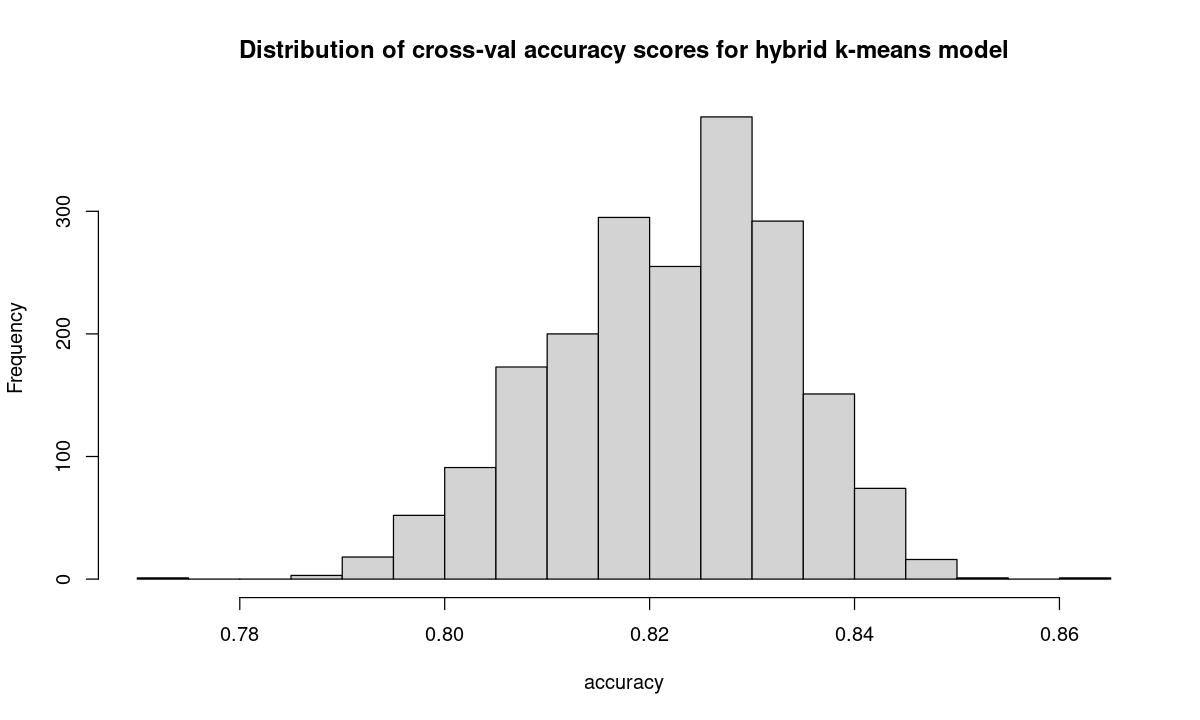

In [34]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(ans$Acc, breaks=14, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for hybrid k-means model")


In [ ]:
### COMMENTS:

# Not only is the min-max scaling taking a bit less time, 
# we are also seeing an important (statistically significant) 
# difference in the scores.  Because I do not think that applying
# weights to this model will get us the boost we need to beat
# the 0.8295 score, I am not going to search for weights.  In
# Part 2 with the cow data, when weights were applied to the 
# base k-means model, the gain was only 0.007 (i.e., less than 
# 1 percentage point).  Here in Part 4 the bar is much higher and,
# thus, we are not likely to see a gain even of 0.007 with the 
# best weights that we find.  (The bar is much higher because we
# have less than half the records to work with and the accuracy
# score we are trying to beat is 11 percentage points higher.)


## Get comparative cross-val score for a hybrid model employing pca

The point of employing pca is to reduce the dimensions of train in order to make it easier to find weights.  But in what follows, I see reason to apply min-max scaling in the process, absent any weights.  This means, in turn, that weights are unlikely to improve upon the following average cross-val accuracy score.

In [35]:
# Apply transformations.

df <- train
df$Phenols <- (df$Phenols)^0.5
df$Alcalinity <- (df$Alcalinity)^0.18


In [52]:
# The R help for prcomp points out that we ought to set
# scale.=TRUE.  If I do not scale, PC1 and PC2 together
# capture around 99% of the variance.  But it is highly
# unlikely we would see such performance on new data.
# Scaling should give us a model that performs better on
# new data.

pca2 <- prcomp(df[, -1], retx=TRUE, rank.=2, center=TRUE,
               scale.=TRUE)
summary(pca2)


Importance of first k=2 (out of 3) components:
                         PC1   PC2
Standard deviation     1.311 0.858
Proportion of Variance 0.573 0.245
Cumulative Proportion  0.573 0.818

In [39]:
kmpca <- as.data.frame(pca2$x)
colnames(kmpca) <- paste0("pc", 1:2)
rownames(kmpca) <- rownames(df)
summary(kmpca)


      pc1               pc2          
 Min.   :-0.6176   Min.   :-0.43125  
 1st Qu.:-0.1952   1st Qu.:-0.10162  
 Median :-0.0593   Median : 0.00229  
 Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.: 0.2143   3rd Qu.: 0.09219  
 Max.   : 0.6158   Max.   : 0.41777  

In [ ]:
# It makes sense to move the data into the range, [0,1],
# because that is where the data for prob01 and prob02 lie.

kmpca_scaled <- apply(kmpca, MARGIN=2, range01)
summary(kmpca_scaled)


In [51]:
# See if pca works better with no transformations on 
# the variables.

pca2_b <- prcomp(train[, -1], retx=TRUE, rank.=2, center=TRUE,
                 scale.=TRUE)
summary(pca2_b)


Importance of first k=2 (out of 3) components:
                         PC1   PC2
Standard deviation     1.300 0.865
Proportion of Variance 0.563 0.249
Cumulative Proportion  0.563 0.813

In [60]:
# Function for obtaining average of confusion matrix accuracy
# score. This function is called from compute_cvScore_km.

get_cvScore_hybrid_pca <- function(traindat, valdat) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    
    prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    # Scale the probability columns.
    prob01_scaled <- scale(prob01, center=TRUE, scale=TRUE)
    prob01_center <- attr(prob01_scaled, "scaled:center")
    prob01_scale <- attr(prob01_scaled, "scaled:scale")
    
    prob02_scaled <- scale(prob02, center=TRUE, scale=TRUE)
    prob02_center <- attr(prob02_scaled, "scaled:center")
    prob02_scale <- attr(prob02_scaled, "scaled:scale")
    
    #############################
    
    # Transform columns of traindat.
    traindat$Phenols <- (traindat$Phenols)^0.5
    traindat$Alcalinity <- (traindat$Alcalinity)^0.18
    
    # Apply pca to traindat.
    pca <- prcomp(traindat[, -1], retx=TRUE, rank.=2, center=TRUE,
                  scale.=TRUE)
    dftmp <- as.data.frame(pca$x, row.names=rownames(traindat))
    
    # Add in the probability columns.
    dftmp$prob01 <- prob01_scaled
    dftmp$prob02 <- prob02_scaled
    
    # Apply min-max scaling.
    dftmp_scaled <- apply(as.matrix(dftmp), MARGIN=2, range01)
    
    traindat_scaled <- as.data.frame(dftmp_scaled, row.names=rownames(traindat))
    colnames(traindat_scaled) <- c(paste0("pc", 1:2),"prob01","prob02")
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(as.matrix(dftmp), MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(as.matrix(dftmp), MARGIN=2, max))
    
    
    ############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    prob01_b <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    prob02_b <- as.numeric(attr(preds01_b, "probabilities")[, 3])
    
    # Scale the probability columns.
    prob01b_scaled <- scale(prob01_b, center=prob01_center, scale=prob01_scale)
    prob02b_scaled <- scale(prob02_b, center=prob02_center, scale=prob02_scale)
    
    # Transform columns of valdat.
    valdat$Phenols <- (valdat$Phenols)^0.5
    valdat$Alcalinity <- (valdat$Alcalinity)^0.18
    
    # Apply pca to valdat.
    valpca <- predict(pca, valdat[, -1])
    df02tmp <- as.data.frame(valpca, row.names=rownames(valdat))
    
    # Add in the probability columns.
    df02tmp$prob01 <- prob01b_scaled
    df02tmp$prob02 <- prob02b_scaled
    
    # Apply min-max scaling.
    df03_t <- t(as.matrix(df02tmp))
    df03_asList <- split(df03_t, seq(nrow(df03_t)))
    names(df03_asList) <- colnames(traindat_scaled)
    valpca_scaled <- mapply(range02, df03_asList, traindat_mins, traindat_maxs)

    # The next step is crucial.
    valdat_scaled <- as.data.frame(valpca_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(traindat_scaled)
    
    
    #############################
    # Construct k-means model.

    kmod <- kmeans(traindat_scaled, 3, iter.max = 50, nstart=30)
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster))
    colnames(dfout) <- c("Type", "cluster")
    rownames(dfout) <- rownames(traindat)
    mapping <- get_mapping(dfout)
    
    #############################
    # Apply the k-means model to valdat_scaled.
    
    # Each element of the following list is a row of valdat_scaled.
    valdat_asList <- split(valdat_scaled[, colnames(kmod$centers)],
                           seq(nrow(valdat_scaled)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_scaled$cluster <- as.numeric(cluster_assgns)
    
    valdat_scaled$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_scaled[which(valdat_scaled$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_scaled[which(valdat_scaled$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_scaled[which(valdat_scaled$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_scaled$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [65]:
# Use the same initial seed as we have been using for
# this score.

set.seed(1931)
seed_vector <- sample(1:9999, 2000, replace=FALSE)

# Here we need to use train instead of df because
# svm02 is using un-transformed columns.

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_km(seed_vector, train)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6.65 mins


[1] "Start time: 2021-06-02 12:42:29"

Time difference of 6.65 mins

In [66]:
summary(ans$Acc)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.785   0.821   0.831   0.830   0.838   0.865 

In [67]:
round(mean(ans$Acc), 4)
# 0.8298

# Section 2 score: 0.8295

# For svm02, this score was 0.8278.


[1] 0.8298

In [68]:
round(median(ans$Acc), 4)
round(sd(ans$Acc), 6)
# 0.8314
# 0.01239

# Section 2 median: 0.8314
# Section 2 sd: 0.012021


[1] 0.8314

[1] 0.01239

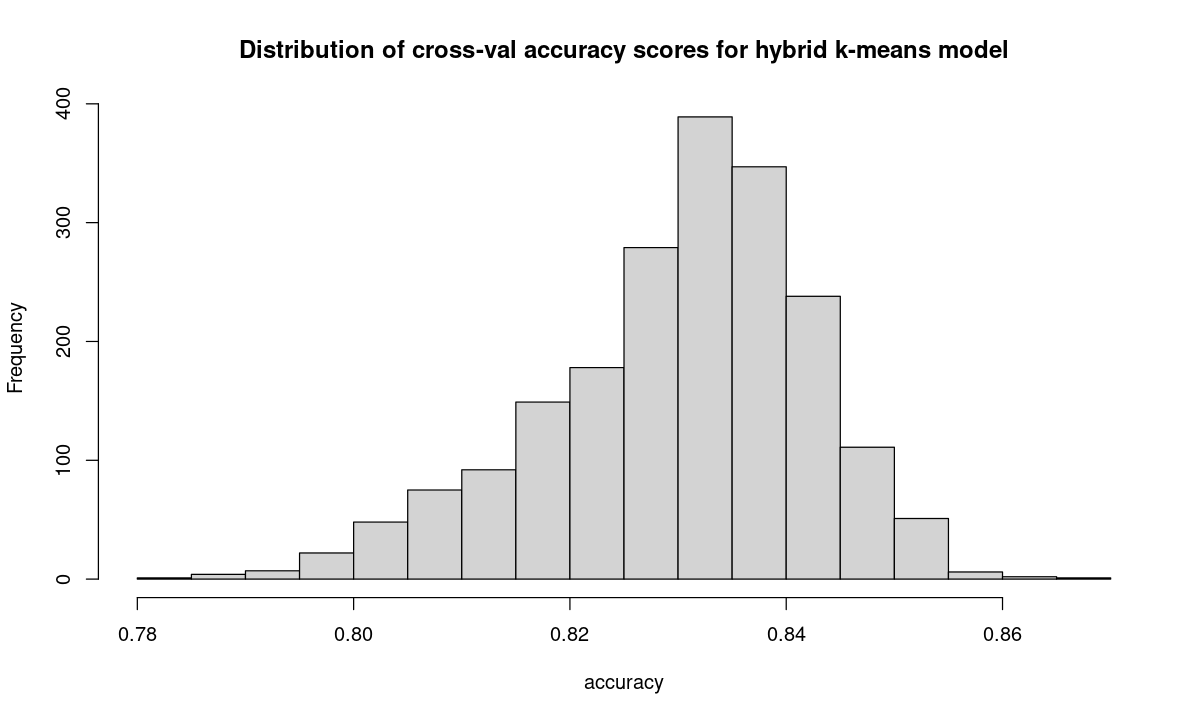

In [69]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(ans$Acc, breaks=14, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for hybrid k-means model")


## See what the variability is in the weights

In [70]:
# With 4 columns, no weights = 0.25 for each column.  
# Keep 0.25 at the center of each sequence.

lst <- vector("list", length= 4)
names(lst) <- c(paste0("pc", 1:2), "prob01","prob02")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- seq(0.13, 0.37, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1,469     4


[1] 1469    4

In [71]:
# Function for computing the tot.withinss for each set of 
# weights in df_params (a dataframe, each row of which is
# a candidate set of weights).  The optimal set of weights
# will be the set that yields the smallest average (over
# the folds) for tot.withinss.
# This function is called from gridSearch07.

get_tot.withinss02 <- function(traindat, valdat, wghts) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    
    prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    # Scale the probability columns.
    prob01_scaled <- scale(prob01, center=TRUE, scale=TRUE)
    prob01_center <- attr(prob01_scaled, "scaled:center")
    prob01_scale <- attr(prob01_scaled, "scaled:scale")
    
    prob02_scaled <- scale(prob02, center=TRUE, scale=TRUE)
    prob02_center <- attr(prob02_scaled, "scaled:center")
    prob02_scale <- attr(prob02_scaled, "scaled:scale")
    
    #############################
    
    # Transform columns of traindat.
    traindat$Phenols <- (traindat$Phenols)^0.5
    traindat$Alcalinity <- (traindat$Alcalinity)^0.18
    
    # Apply pca to traindat.
    pca <- prcomp(traindat[, -1], retx=TRUE, rank.=2, center=TRUE,
                  scale.=TRUE)
    dftmp <- as.data.frame(pca$x, row.names=rownames(traindat))
    
    # Add in the probability columns.
    dftmp$prob01 <- prob01_scaled
    dftmp$prob02 <- prob02_scaled
    
    # Apply min-max scaling.
    # dftmp_scaled <- apply(as.matrix(dftmp), MARGIN=2, range01)
    
    # traindat_scaled <- as.data.frame(dftmp_scaled, row.names=rownames(traindat))
    # colnames(traindat_scaled) <- c(paste0("pc", 1:2),"prob01","prob02")
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(as.matrix(dftmp), MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(as.matrix(dftmp), MARGIN=2, max))
    
    
    
    ############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    prob01_b <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    prob02_b <- as.numeric(attr(preds01_b, "probabilities")[, 3])
    
    # Scale the probability columns.
    prob01b_scaled <- scale(prob01_b, center=prob01_center, scale=prob01_scale)
    prob02b_scaled <- scale(prob02_b, center=prob02_center, scale=prob02_scale)
    
    # Transform columns of valdat.
    valdat$Phenols <- (valdat$Phenols)^0.5
    valdat$Alcalinity <- (valdat$Alcalinity)^0.18
    
    # Apply pca to valdat.
    valpca <- predict(pca, valdat[, -1])
    df02tmp <- as.data.frame(valpca, row.names=rownames(valdat))
    
    # Add in the probability columns.
    df02tmp$prob01 <- prob01b_scaled
    df02tmp$prob02 <- prob02b_scaled
    
    # Apply min-max scaling.
    df03_t <- t(as.matrix(df02tmp))
    df03_asList <- split(df03_t, seq(nrow(df03_t)))
    names(df03_asList) <- c(paste0("pc", 1:2),"prob01","prob02")
    valpca_scaled <- mapply(range02, df03_asList, traindat_mins, traindat_maxs)

    # The next step is crucial.
    valdat_scaled <- as.data.frame(valpca_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- c(paste0("pc", 1:2),"prob01","prob02")
    
    
    # Apply weights to valdat_scaled.
    cols <- names(wghts)
    df4 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    # valdat_wghts <- as.data.frame(df4, row.names=rownames(valdat))
    # colnames(valdat_wghts) <- cols
    
    
    #############################################
    # Construct k-means model on the validation set.

    kmod <- kmeans(df4, 3, iter.max = 50, nstart=30)
    
    return(kmod$tot.withinss)
}


In [77]:
# Test on a sample of 100.

set.seed(42)
smp <- sample(rownames(dfc01), 100, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


,pc1,pc2,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>
11425,0.33,0.27,0.17,0.23
7201,0.35,0.27,0.19,0.19
22165,0.37,0.15,0.15,0.33
20509,0.27,0.21,0.21,0.31
23329,0.25,0.13,0.29,0.33
22057,0.29,0.25,0.13,0.33


In [78]:
# Find the best weights of those in tst_params.
# Use 120 seeds.

set.seed(1233)
seed_vector <- sample(1:9999, 120, replace=FALSE)

start <- Sys.time()
paste0("Start time: ", start)
dat_result <- gridSearch07(seed_vector, train, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 7.06 mins (for 100 rows; 120 seeds each row)


[1] "Start time: 2021-06-02 13:53:22"

Time difference of 7.06 mins

In [79]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [80]:
dfc01[best_params,]

best_tot.withinss


,pc1,pc2,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>
26377,0.37,0.13,0.13,0.37


[1] 0.46

In [81]:
# Find the best weights of those in dfc01.
# Use 120 seeds.  [Approx. time: 1.75 hours]

set.seed(1233)
seed_vector <- sample(1:9999, 120, replace=FALSE)

start <- Sys.time()
paste0("Start time: ", start)
dat_result <- gridSearch07(seed_vector, train, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
datout_01 <- dat_result
# Time difference of 1.8 hours.


[1] "Start time: 2021-06-02 14:03:20"

Time difference of 1.8 hours

In [82]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [83]:
dfc01[best_params,]
#       	 pc1	 pc2	prob01  	prob02

# 26377 	0.37	0.13	  0.13  	  0.37

best_tot.withinss
# 0.4615


,pc1,pc2,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>
26377,0.37,0.13,0.13,0.37


[1] 0.4615

In [84]:
datout_01 <- datout_01[order(datout_01$tot.withinss, decreasing=FALSE),]
datout_01[1:15,]


,row,tot.withinss
,<chr>,<dbl>
1379,26377,0.46152
1289,24349,0.46377
1277,24193,0.46483
1189,22321,0.46559
1392,26545,0.46580
1380,26389,0.46712
1081,20293,0.46731
1177,22165,0.46735
1302,24517,0.46798


In [86]:
bestrows <- (datout_01$row)[1:6]
dfc02 <- as.data.frame(cbind(dfc01[bestrows,], datout_01[1:6, c("tot.withinss")]),
                       row.names=bestrows)
colnames(dfc02) <- c(colnames(dfc01), "tot.withinss")
dfc02


,pc1,pc2,prob01,prob02,tot.withinss
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26377,0.37,0.13,0.13,0.37,0.46152
24349,0.37,0.13,0.15,0.35,0.46377
24193,0.37,0.15,0.13,0.35,0.46483
22321,0.37,0.13,0.17,0.33,0.46559
26545,0.35,0.13,0.15,0.37,0.46580
26389,0.35,0.15,0.13,0.37,0.46712


In [16]:
# Refine the search, this time using cross-val accuracy scores.

lst <- vector("list", length= 4)
names(lst) <- c(paste0("pc", 1:2), "prob01","prob02")

lst[[1]] <- seq(0.36, 0.39, by=0.01)
lst[[2]] <- seq(0.11, 0.14, by=0.01)
lst[[3]] <- seq(0.11, 0.14, by=0.01)
lst[[4]] <- seq(0.36, 0.39, by=0.01)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  44     4


[1] 44  4

In [22]:
# Function for obtaining average of confusion matrix accuracy
# score. This function is called from gridSearch03.

get_cvScore_hybrid_pcaWghts <- function(traindat, valdat, wghts) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    
    prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    # Scale the probability columns.
    prob01_scaled <- scale(prob01, center=TRUE, scale=TRUE)
    prob01_center <- attr(prob01_scaled, "scaled:center")
    prob01_scale <- attr(prob01_scaled, "scaled:scale")
    
    prob02_scaled <- scale(prob02, center=TRUE, scale=TRUE)
    prob02_center <- attr(prob02_scaled, "scaled:center")
    prob02_scale <- attr(prob02_scaled, "scaled:scale")
    
    #############################
    
    # Transform columns of traindat.
    traindat$Phenols <- (traindat$Phenols)^0.5
    traindat$Alcalinity <- (traindat$Alcalinity)^0.18
    
    # Apply pca to traindat.
    pca <- prcomp(traindat[, -1], retx=TRUE, rank.=2, center=TRUE,
                  scale.=TRUE)
    dftmp <- as.data.frame(pca$x, row.names=rownames(traindat))
    
    # Add in the probability columns.
    dftmp$prob01 <- prob01_scaled
    dftmp$prob02 <- prob02_scaled
    
    # Apply min-max scaling.
    dftmp_scaled <- apply(as.matrix(dftmp), MARGIN=2, range01)
    
    traindat_scaled <- as.data.frame(dftmp_scaled, row.names=rownames(traindat))
    colnames(traindat_scaled) <- c(paste0("pc", 1:2),"prob01","prob02")
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(as.matrix(dftmp), MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(as.matrix(dftmp), MARGIN=2, max))
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    
    
    ############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    prob01_b <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    prob02_b <- as.numeric(attr(preds01_b, "probabilities")[, 3])
    
    # Scale the probability columns.
    prob01b_scaled <- scale(prob01_b, center=prob01_center, scale=prob01_scale)
    prob02b_scaled <- scale(prob02_b, center=prob02_center, scale=prob02_scale)
    
    # Transform columns of valdat.
    valdat$Phenols <- (valdat$Phenols)^0.5
    valdat$Alcalinity <- (valdat$Alcalinity)^0.18
    
    # Apply pca to valdat.
    valpca <- predict(pca, valdat[, -1])
    df02tmp <- as.data.frame(valpca, row.names=rownames(valdat))
    
    # Add in the probability columns.
    df02tmp$prob01 <- prob01b_scaled
    df02tmp$prob02 <- prob02b_scaled
    
    # Apply min-max scaling.
    df03_t <- t(as.matrix(df02tmp))
    df03_asList <- split(df03_t, seq(nrow(df03_t)))
    names(df03_asList) <- colnames(traindat_scaled)
    valpca_scaled <- mapply(range02, df03_asList, traindat_mins, traindat_maxs)

    # The next step is crucial.
    valdat_scaled <- as.data.frame(valpca_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(traindat_scaled)
    
    # Apply weights to valdat_scaled.
    df4 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df4, row.names=rownames(valdat))
    colnames(valdat_wghts) <- colnames(traindat_scaled)
    
    
    #############################
    # Construct k-means model.

    kmod <- kmeans(traindat_wghts, 3, iter.max = 50, nstart=30)
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster))
    colnames(dfout) <- c("Type", "cluster")
    rownames(dfout) <- rownames(traindat)
    mapping <- get_mapping(dfout)
    
    #############################
    # Apply the k-means model to valdat_scaled.
    
    # Each element of the following list is a row of valdat_scaled.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_scaled$cluster <- as.numeric(cluster_assgns)
    
    valdat_scaled$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_scaled[which(valdat_scaled$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_scaled[which(valdat_scaled$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_scaled[which(valdat_scaled$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_scaled$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [23]:
# Find the best weights of those in dfc02.
# Use 120 seeds.

set.seed(1233)
seed_vector <- sample(1:9999, 120, replace=FALSE)

start <- Sys.time()
paste0("Start time: ", start)
dat_result <- gridSearch03(seed_vector, train, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
datout_02 <- dat_result
# Time difference of 16.12 mins


[1] "Start time: 2021-06-03 09:24:59"

Time difference of 16.12 mins

In [24]:
best_params <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$row
length(best_params)

best_Acc <- dat_result[which(dat_result$Acc == 
                                max(dat_result$Acc, na.rm=TRUE)),]$Acc


[1] 1

In [25]:
dfc02[best_params,]
#       	 pc1    	 pc2 	prob01  	prob02

# 58    	0.37    	0.13 	  0.14  	  0.36

best_Acc


,pc1,pc2,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>
58,0.37,0.13,0.14,0.36


[1] 0.83172

In [26]:
datout_02 <- datout_02[order(datout_02$Acc, decreasing=TRUE),]
datout_02[1:15,]


,row,Acc
,<chr>,<dbl>
9,58,0.83172
32,169,0.83161
44,241,0.83150
34,181,0.83141
7,52,0.83100
33,178,0.83081
40,214,0.83077
22,121,0.83072
10,61,0.83071


In [27]:
bestrows <- (datout_02$row)[1:5]
dfc03 <- as.data.frame(cbind(dfc02[bestrows,], datout_02[1:5, c("Acc")]),
                       row.names=bestrows)
colnames(dfc03) <- c(colnames(dfc02), "Acc")
dfc03


,pc1,pc2,prob01,prob02,Acc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58,0.37,0.13,0.14,0.36,0.83172
169,0.36,0.13,0.13,0.38,0.83161
241,0.36,0.11,0.14,0.39,0.83150
181,0.36,0.12,0.14,0.38,0.83141
52,0.39,0.11,0.14,0.36,0.83100


In [ ]:
### COMMENT:

# I could continue to search for even better
# weights.  But instead, let's see if we can
# get a cross-val accuracy score that equals
# or exceeds 0.8310 with the row 58 weights above.


## Get comparative cross-val score for pca hybrid model with weights

In [28]:
# Function for obtaining average of confusion matrix accuracy
# score. This function is called from get_cvScore_km.

wghts <- c(0.37, 0.13, 0.14, 0.36)^0.5
names(wghts) <- c(paste0("pc", 1:2), "prob01","prob02")

get_cvScore_pcaHybrid_wghts <- function(traindat, valdat) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Type, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Type)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.03, cost= 25, scale=FALSE, probability=TRUE)
    
    preds <- predict(svmod, newdata=svm_scaled, scale=FALSE, probability=TRUE)
    
    prob01 <- as.numeric(attr(preds, "probabilities")[, 2])
    prob02 <- as.numeric(attr(preds, "probabilities")[, 3])
    
    # Scale the probability columns.
    prob01_scaled <- scale(prob01, center=TRUE, scale=TRUE)
    prob01_center <- attr(prob01_scaled, "scaled:center")
    prob01_scale <- attr(prob01_scaled, "scaled:scale")
    
    prob02_scaled <- scale(prob02, center=TRUE, scale=TRUE)
    prob02_center <- attr(prob02_scaled, "scaled:center")
    prob02_scale <- attr(prob02_scaled, "scaled:scale")
    
    #############################
    
    # Transform columns of traindat.
    traindat$Phenols <- (traindat$Phenols)^0.5
    traindat$Alcalinity <- (traindat$Alcalinity)^0.18
    
    # Apply pca to traindat.
    pca <- prcomp(traindat[, -1], retx=TRUE, rank.=2, center=TRUE,
                  scale.=TRUE)
    dftmp <- as.data.frame(pca$x, row.names=rownames(traindat))
    
    # Add in the probability columns.
    dftmp$prob01 <- prob01_scaled
    dftmp$prob02 <- prob02_scaled
    
    # Apply min-max scaling.
    dftmp_scaled <- apply(as.matrix(dftmp), MARGIN=2, range01)
    
    traindat_scaled <- as.data.frame(dftmp_scaled, row.names=rownames(traindat))
    colnames(traindat_scaled) <- c(paste0("pc", 1:2),"prob01","prob02")
    
    # Get mins and maxs for scaling of valdat.
    traindat_mins <- as.numeric(apply(as.matrix(dftmp), MARGIN=2, min))
    traindat_maxs <- as.numeric(apply(as.matrix(dftmp), MARGIN=2, max))
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    
    
    ############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02 columns.
    preds01_b <- predict(svmod, newdata=svmval_scaled, scale=FALSE, probability=TRUE)
    prob01_b <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    prob02_b <- as.numeric(attr(preds01_b, "probabilities")[, 3])
    
    # Scale the probability columns.
    prob01b_scaled <- scale(prob01_b, center=prob01_center, scale=prob01_scale)
    prob02b_scaled <- scale(prob02_b, center=prob02_center, scale=prob02_scale)
    
    # Transform columns of valdat.
    valdat$Phenols <- (valdat$Phenols)^0.5
    valdat$Alcalinity <- (valdat$Alcalinity)^0.18
    
    # Apply pca to valdat.
    valpca <- predict(pca, valdat[, -1])
    df02tmp <- as.data.frame(valpca, row.names=rownames(valdat))
    
    # Add in the probability columns.
    df02tmp$prob01 <- prob01b_scaled
    df02tmp$prob02 <- prob02b_scaled
    
    # Apply min-max scaling.
    df03_t <- t(as.matrix(df02tmp))
    df03_asList <- split(df03_t, seq(nrow(df03_t)))
    names(df03_asList) <- colnames(traindat_scaled)
    valpca_scaled <- mapply(range02, df03_asList, traindat_mins, traindat_maxs)

    # The next step is crucial.
    valdat_scaled <- as.data.frame(valpca_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(traindat_scaled)
    
    # Apply weights to valdat_scaled.
    df4 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df4, row.names=rownames(valdat))
    colnames(valdat_wghts) <- colnames(traindat_scaled)
    
    
    #############################
    # Construct k-means model.

    kmod <- kmeans(traindat_wghts, 3, iter.max = 50, nstart=30)
    
    # See how the clusters are associated with Type level.
    dfout <- as.data.frame(cbind(traindat$Type, kmod$cluster))
    colnames(dfout) <- c("Type", "cluster")
    rownames(dfout) <- rownames(traindat)
    mapping <- get_mapping(dfout)
    
    #############################
    # Apply the k-means model to valdat_scaled.
    
    # Each element of the following list is a row of valdat_scaled.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, USE.NAMES= FALSE, mc.cores=6)
    
    valdat_scaled$cluster <- as.numeric(cluster_assgns)
    
    valdat_scaled$pred_Type <- NA
    
    # Apply mapping to the assigned clusters.  Since valdat is 
    # quite small (around 35 records if folds = 5), and there 
    # are 3 clusters, it is possible that one of the LHS expressions
    # below is NA.  I will make the changes if the program fails. 
    valdat_scaled[which(valdat_scaled$cluster==1), c("pred_Type")] <- as.numeric(mapping["1"])
    valdat_scaled[which(valdat_scaled$cluster==2), c("pred_Type")] <- as.numeric(mapping["2"])
    valdat_scaled[which(valdat_scaled$cluster==3), c("pred_Type")] <- as.numeric(mapping["3"])
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_scaled$pred_Type)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Type", drop=FALSE])
    return(ans[[2]])
}


In [30]:
# Again, use the same initial seed that we have 
# been using for this score.

set.seed(1931)
seed_vector <- sample(1:9999, 2000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_km(seed_vector, train)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.48 mins


[1] "Start time: 2021-06-03 10:01:28"

Time difference of 6.43 mins

In [31]:
summary(ans$Acc)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.775   0.821   0.831   0.830   0.838   0.865 

In [32]:
round(mean(ans$Acc), 4)
# 0.8304

# svm02's mean accuracy score was 0.8278.


[1] 0.8304

In [33]:
round(median(ans$Acc), 4)
round(sd(ans$Acc), 6)
# median: 0.8314
# sd: 0.012394


[1] 0.8314

[1] 0.012394

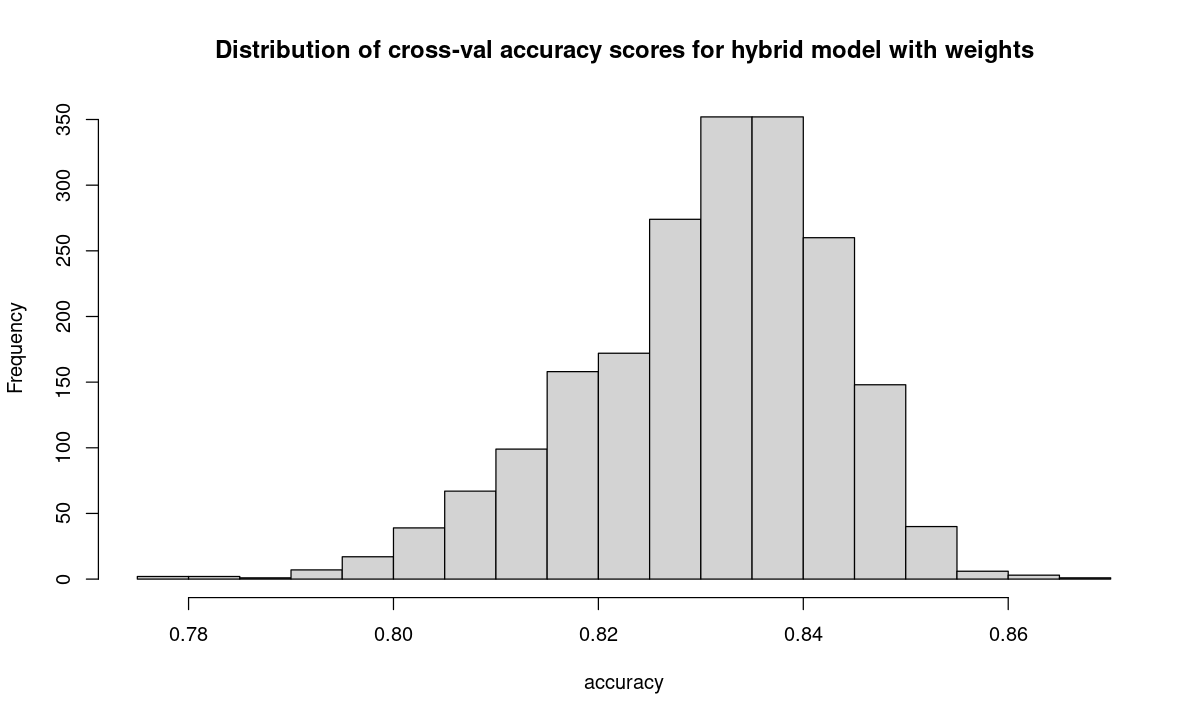

In [34]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(ans$Acc, breaks=16, xlab="accuracy",
     main="Distribution of cross-val accuracy scores for hybrid model with weights")


# Final Comments for Part 4

Excluding the k-means models, the best model we found for the wine dataset was svm02.  svm02 has a mean cross-val accuracy score of 0.8278 and a median cross-val accuracy score of 0.8271.  We found a hybrid k-means model (without weights) that was able to slightly improve upon this score.  This hybrid model has a mean cross-val accuracy score of 0.8295 and a median cross-val accuracy score of 0.8314.  (All scores are over 2000 samples.)

Although this hybrid model's improvement upon svm02 is slight, it is statistically significant.  If we chose a weaker set of 3 predictors from the wine dataset, the best model accuracy score will decrease.  This lowers the bar for the k-means hybrid model; i.e., it may increase the likelihood that the k-means hybrid model will outperform the competing models.  In the Part 1 and Part 2 notebooks which worked with the cow data, the bar was lower---around 0.70 for the best non-k-means model.  There the hybrid k-means model (with weights) had an average accuracy score of 0.73.

Above, in one of the Comments, I note that in previous work on the wine dataset I chose a different set of 3 predictors for Type.  In that work the best non-k-means model had a mean cross-val accuracy score of 0.9056.  The best hybrid k-means model I was able to find had a score of 0.9013.  In this notebook, the 3 predictors chosen lowered the accuracy score bar to just under 0.83.  This was enough that a hybrid k-means model could improve upon the score.  In the last section above, I create a different hybrid model that yields a further incremental improvement: over 2000 samples we were able to boost the average score to 0.8304.  The median score, however, remained at 0.8314.

The next step would be to choose a third set of 3 predictors, ones that lower the accuracy score of the best models even further, and then see if k-means is able to improve upon the best models, and by how much.  Like other models, how well k-means does depends on the predictors chosen, so improvement isn't guaranteed simply because the highest accuracy score of the competing models is lower.  But a lower accuracy score does mean more opportunity exists for a model like k-means to give a boost to the best of those lower scores.
